<a href="https://colab.research.google.com/github/mohammadabid-macad/MiamiParks/blob/main/Miami_v15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Necessary Libraries

In [ ]:
# Install necessary libraries
!pip install osmnx geopandas geopy matplotlib

In [ ]:
import torch
torch.__version__

'2.2.1+cu121'

In [ ]:
!pip install torch===2.2.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip install dgl

In [ ]:
# Import necessary libraries
import osmnx as ox
import geopandas as gpd
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from shapely.geometry import Point
from shapely.ops import nearest_points
from matplotlib.patches import Circle
from google.colab import drive
import matplotlib.pyplot as plt


## Define the Area of Interest and Load the Street Network

In [ ]:
# Define the area of interest
place = 'Miami, Miami-Dade County, Florida, United States'

utm_crs = 'epsg:32617'  # UTM Zone 17N for Miami-Dade

# Load the street network and project it
G = ox.graph_from_place(place, network_type='walk')
G = ox.project_graph(G, to_crs=utm_crs)


## 0: Data Importing

In [ ]:
import geopandas as gpd
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path in Google Drive
pickle_file_path_drive = '/content/drive/MyDrive/Miami Parks/parks_businesses_combined.pkl'

# Load the GeoDataFrame from the specified path in Google Drive
with open(pickle_file_path_drive, 'rb') as f:
    gdf = pickle.load(f)

# Display the first few rows to verify
print(gdf.head())

Mounted at /content/drive
   OBJECTID          FOLIO      ID                                NAME  \
0        16  0141040000040  410401        Miami-Dade County Auditorium   
1        21  0131140180310  311419                   Alonzo Kelly Park   
2        78                 311511  Martin Luther King Blvd (NW 62 ST)   
3       146  0131140190180  311420                            Area 226   
4       147  0131140351200  311421                            Area 227   

                    ADDRESS   CITY  ZIPCODE  park_totalAcreage       LAT  \
0      2901 WEST FLAGLER ST  MIAMI  33125.0               9.47  25.77366   
1           1455 NW 67TH ST  MIAMI  33147.0               0.50  25.83585   
2           6100 NW 32ND CT  MIAMI  33150.0               0.00  25.83185   
3            875 NW 70TH ST  MIAMI  33150.0               0.50  25.83892   
4  NW 59TH ST / NW 15TH AVE  MIAMI  33142.0               0.50  25.82984   

        LON  ... class_Greenway Park class_Metropolitan Park class_Mini 

In [ ]:
# Ensure 'B_avgScore' is correctly converted to numeric if not already
gdf['B_avgScore'] = pd.to_numeric(gdf['B_avgScore'], errors='coerce')

# Fill missing values in park_reviewsCount with 0
gdf['park_reviewsCount'] = gdf['park_reviewsCount'].fillna(0)

# Create a new DataFrame with only the important columns (excluding park class columns)
important_columns = [
    'park_geometry', 'B_geometry', 'buffer', 'B_avgScore', 'park_totalAcreage',
    'park_numFeatures', 'park_reviewsCount', 'park_avgScore', 'NAME', 'osm_id'
]

comparison_gdf = gdf[important_columns]

# Ensure 'park_geometry' is set as the primary geometry column
comparison_gdf = gpd.GeoDataFrame(comparison_gdf, geometry='park_geometry')

# Check the geometry types
print(f"Geometry types in 'park_geometry': {comparison_gdf['park_geometry'].geom_type.unique()}")
print(f"Geometry types in 'B_geometry': {comparison_gdf['B_geometry'].geom_type.unique()}")
print(f"Geometry types in 'buffer': {comparison_gdf['buffer'].geom_type.unique()}")

# Separate the rows with missing park_avgScore for later prediction
missing_park_avgScore = comparison_gdf[comparison_gdf['park_avgScore'].isna()]
complete_park_avgScore = comparison_gdf.dropna(subset=['park_avgScore'])

# Verify the new DataFrame and data types
print(comparison_gdf.head())
print(comparison_gdf.dtypes)

print(f"Number of rows with missing park_avgScore: {len(missing_park_avgScore)}")
print(f"Number of rows with complete park_avgScore: {len(complete_park_avgScore)}")


Geometry types in 'park_geometry': ['Point']
Geometry types in 'B_geometry': ['MultiPoint' 'Point']
Geometry types in 'buffer': ['Polygon']
                    park_geometry  \
0  POINT (576087.992 2850838.119)   
1  POINT (577947.489 2857736.561)   
2  POINT (578096.439 2857294.438)   
3  POINT (578944.667 2858082.507)   
4  POINT (577908.329 2857070.714)   

                                          B_geometry  \
0  MULTIPOINT (576132.094 2851499.087, 576268.711...   
1  MULTIPOINT (578543.142 2857280.391, 577835.584...   
2  MULTIPOINT (578543.142 2857280.391, 577835.584...   
3  MULTIPOINT (579329.948 2857908.869, 579287.778...   
4  MULTIPOINT (578543.142 2857280.391, 577704.120...   

                                              buffer  B_avgScore  \
0  POLYGON ((576920.992 2850838.119, 576916.981 2...    4.221661   
1  POLYGON ((578780.489 2857736.561, 578776.478 2...    4.182504   
2  POLYGON ((578929.439 2857294.438, 578925.428 2...    3.997512   
3  POLYGON ((579777.667 2858

## 1: Data Preprocessing

### Step 1.1: Load and Prepare Data

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from google.colab import drive
import pickle
import torch

# Mount Google Drive
drive.mount('/content/drive')

# Load the GeoDataFrame
pickle_file_path_drive = '/content/drive/MyDrive/Miami Parks/parks_businesses_combined.pkl'
with open(pickle_file_path_drive, 'rb') as f:
    gdf = pickle.load(f)

# Display the first few rows to verify
print(gdf.head())

# Ensure 'B_avgScore' is correctly converted to numeric if not already
gdf['B_avgScore'] = pd.to_numeric(gdf['B_avgScore'], errors='coerce')

# Fill missing values in park_reviewsCount with 0
gdf['park_reviewsCount'] = gdf['park_reviewsCount'].fillna(0)

# Create a new DataFrame with only the important columns (excluding park class columns)
important_columns = [
    'park_geometry', 'B_geometry', 'buffer', 'B_avgScore', 'park_totalAcreage',
    'park_numFeatures', 'park_reviewsCount', 'park_avgScore', 'NAME', 'osm_id'
]

comparison_gdf = gdf[important_columns]

# Ensure 'park_geometry' is set as the primary geometry column
comparison_gdf = gpd.GeoDataFrame(comparison_gdf, geometry='park_geometry')

# Check the geometry types
print(f"Geometry types in 'park_geometry': {comparison_gdf['park_geometry'].geom_type.unique()}")
print(f"Geometry types in 'B_geometry': {comparison_gdf['B_geometry'].geom_type.unique()}")
print(f"Geometry types in 'buffer': {comparison_gdf['buffer'].geom_type.unique()}")

# Separate the rows with missing park_avgScore for later prediction
missing_park_avgScore = comparison_gdf[comparison_gdf['park_avgScore'].isna()]
complete_park_avgScore = comparison_gdf.dropna(subset=['park_avgScore'])

# Verify the new DataFrame and data types
print(comparison_gdf.head())
print(comparison_gdf.dtypes)

print(f"Number of rows with missing park_avgScore: {len(missing_park_avgScore)}")
print(f"Number of rows with complete park_avgScore: {len(complete_park_avgScore)}")

# Count None values in each column
print(f"None values in each column:\n{comparison_gdf.isna().sum()}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   OBJECTID          FOLIO      ID                                NAME  \
0        16  0141040000040  410401        Miami-Dade County Auditorium   
1        21  0131140180310  311419                   Alonzo Kelly Park   
2        78                 311511  Martin Luther King Blvd (NW 62 ST)   
3       146  0131140190180  311420                            Area 226   
4       147  0131140351200  311421                            Area 227   

                    ADDRESS   CITY  ZIPCODE  park_totalAcreage       LAT  \
0      2901 WEST FLAGLER ST  MIAMI  33125.0               9.47  25.77366   
1           1455 NW 67TH ST  MIAMI  33147.0               0.50  25.83585   
2           6100 NW 32ND CT  MIAMI  33150.0               0.00  25.83185   
3            875 NW 70TH ST  MIAMI  33150.0               0.50  25.83892   
4  NW 59TH ST / NW 15TH AVE  MIAMI  33142.0   

### Step 1.2: Assign Node Classes

In [ ]:
# Assign node classes based on park_avgScore using specified ranges
def assign_node_class(score):
    if pd.isna(score):
        return 6  # Class 6 for unknown scores
    elif score <= 0.4:
        return 0
    elif score <= 1.4:
        return 1
    elif score <= 2.4:
        return 2
    elif score <= 3.4:
        return 3
    elif score <= 4.4:
        return 4
    else:
        return 5

comparison_gdf['node_class'] = comparison_gdf['park_avgScore'].apply(assign_node_class)
node_classes = comparison_gdf['node_class'].values.reshape(-1, 1)

# One-hot encode the node classes
encoder = OneHotEncoder(sparse_output=False, categories='auto')
encoder.fit(np.array([0, 1, 2, 3, 4, 5, 6]).reshape(-1, 1))  # Fit the encoder with all possible classes
node_classes_one_hot = encoder.transform(node_classes)

# Create a DataFrame with the correct columns
node_classes_df = pd.DataFrame(node_classes_one_hot, columns=[f'class_{i}' for i in range(7)])

# Add the one-hot encoded classes back to the GeoDataFrame
comparison_gdf = pd.concat([comparison_gdf.reset_index(drop=True), node_classes_df], axis=1)


### Step 1.3: Extract Coordinates

In [ ]:
# Extract coordinates for park_geometry, B_geometry, and buffer
def extract_coordinates(geom):
    if geom.geom_type == 'Point':
        return [geom.x, geom.y]
    elif geom.geom_type == 'MultiPoint':
        return [[point.x, point.y] for point in geom.geoms]
    elif geom.geom_type == 'Polygon':
        return list(geom.exterior.coords)
    else:
        return []

comparison_gdf['park_coords'] = comparison_gdf['park_geometry'].apply(extract_coordinates)
comparison_gdf['B_coords'] = comparison_gdf['B_geometry'].apply(extract_coordinates)
comparison_gdf['buffer_coords'] = comparison_gdf['buffer'].apply(extract_coordinates)


### Step 1.4: Normalize Features

In [ ]:
# Normalize features
nodes_attributes = ['B_avgScore', 'park_totalAcreage', 'park_numFeatures', 'park_reviewsCount']
valid_rows = comparison_gdf.dropna(subset=nodes_attributes)
scaler = StandardScaler()
normalized_features = scaler.fit_transform(valid_rows[nodes_attributes].fillna(0))

# Assign normalized features to nodes
for i, feature in enumerate(nodes_attributes):
    comparison_gdf[feature + '_norm'] = normalized_features[:, i]

# Create tensor of node features
node_features = torch.tensor(normalized_features, dtype=torch.float32)

# Verify node features
print("Node features tensor:")
print(node_features[:5])
print(comparison_gdf.head())
print(comparison_gdf.dtypes)


Node features tensor:
tensor([[-0.0646, -0.0531, -0.2937, -0.2601],
        [-0.2118, -0.2003,  0.6797, -0.2437],
        [-0.9069, -0.2085, -0.2937, -0.1858],
        [-1.0566, -0.2003,  1.6530, -0.2601],
        [-0.7936, -0.2003,  0.6797, -0.1858]])
                    park_geometry  \
0  POINT (576087.992 2850838.119)   
1  POINT (577947.489 2857736.561)   
2  POINT (578096.439 2857294.438)   
3  POINT (578944.667 2858082.507)   
4  POINT (577908.329 2857070.714)   

                                          B_geometry  \
0  MULTIPOINT (576132.094 2851499.087, 576268.711...   
1  MULTIPOINT (578543.142 2857280.391, 577835.584...   
2  MULTIPOINT (578543.142 2857280.391, 577835.584...   
3  MULTIPOINT (579329.948 2857908.869, 579287.778...   
4  MULTIPOINT (578543.142 2857280.391, 577704.120...   

                                              buffer  B_avgScore  \
0  POLYGON ((576920.992 2850838.119, 576916.981 2...    4.221661   
1  POLYGON ((578780.489 2857736.561, 578776.478 2..

### Step 1.5: Verify Data

In [ ]:
# Verify the processed data
print("Processed DataFrame:")
print(comparison_gdf.head())
print("Data types of each column:")
print(comparison_gdf.dtypes)
print(f"Number of rows with missing park_avgScore: {len(missing_park_avgScore)}")
print(f"Number of rows with complete park_avgScore: {len(complete_park_avgScore)}")
print(f"None values in each column:\n{comparison_gdf.isna().sum()}")


Processed DataFrame:
                    park_geometry  \
0  POINT (576087.992 2850838.119)   
1  POINT (577947.489 2857736.561)   
2  POINT (578096.439 2857294.438)   
3  POINT (578944.667 2858082.507)   
4  POINT (577908.329 2857070.714)   

                                          B_geometry  \
0  MULTIPOINT (576132.094 2851499.087, 576268.711...   
1  MULTIPOINT (578543.142 2857280.391, 577835.584...   
2  MULTIPOINT (578543.142 2857280.391, 577835.584...   
3  MULTIPOINT (579329.948 2857908.869, 579287.778...   
4  MULTIPOINT (578543.142 2857280.391, 577704.120...   

                                              buffer  B_avgScore  \
0  POLYGON ((576920.992 2850838.119, 576916.981 2...    4.221661   
1  POLYGON ((578780.489 2857736.561, 578776.478 2...    4.182504   
2  POLYGON ((578929.439 2857294.438, 578925.428 2...    3.997512   
3  POLYGON ((579777.667 2858082.507, 579773.656 2...    3.957663   
4  POLYGON ((578741.329 2857070.714, 578737.318 2...    4.027651   

   park_to

## 2: Create Nodes and Edges for the Graph



### 2.1: Find and Assign Nearest Street Nodes to Park Nodes

In [ ]:
import osmnx as ox

# Define the area of interest
place = 'Miami, Miami-Dade County, Florida, United States'
utm_crs = 'epsg:32617'  # UTM Zone 17N for Miami-Dade

# Load the street network and project it
G = ox.graph_from_place(place, network_type='walk')
G = ox.project_graph(G, to_crs=utm_crs)

# Extract park coordinates and find the nearest street nodes
park_coords = comparison_gdf['park_geometry'].apply(lambda geom: (geom.y, geom.x)).tolist()
nearest_nodes = [ox.distance.nearest_nodes(G, point[1], point[0]) for point in park_coords]
comparison_gdf['nearest_street_node'] = nearest_nodes

# Verify the column
print("Comparison GDF with 'nearest_street_node':")
print(comparison_gdf[['park_geometry', 'nearest_street_node', 'node_class']].head())


Comparison GDF with 'nearest_street_node':
                    park_geometry  nearest_street_node  node_class
0  POINT (576087.992 2850838.119)           9953901250           6
1  POINT (577947.489 2857736.561)           7509369823           4
2  POINT (578096.439 2857294.438)             99180299           4
3  POINT (578944.667 2858082.507)           5442639262           6
4  POINT (577908.329 2857070.714)             99278505           4


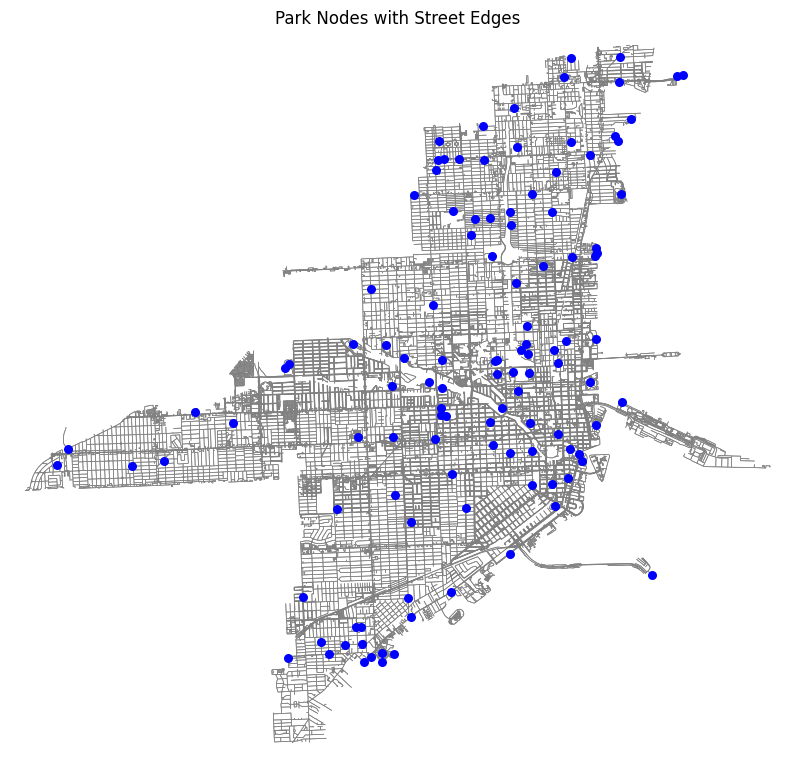

In [ ]:
# Plot park nodes with valid positions and street edges
import matplotlib.pyplot as plt
import networkx as nx

# Extract valid park nodes
valid_park_nodes = comparison_gdf[comparison_gdf['nearest_street_node'].notnull()]['nearest_street_node'].unique()

# Plot the graph
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G, ax=ax, node_size=0, edge_color='grey', edge_linewidth=0.5, show=False, close=False)

# Plot park nodes
valid_positions = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in valid_park_nodes if node in G.nodes}
nx.draw_networkx_nodes(G, pos=valid_positions, nodelist=valid_positions.keys(), node_color='blue', node_size=30, ax=ax, label='Park Nodes')

ax.set_title('Park Nodes with Street Edges')
plt.show()


### 2.2: Node Classification

In [ ]:
# Check the columns in comparison_gdf to ensure 'nearest_street_node' is present
print("Comparison GDF columns:", comparison_gdf.columns)

# Check the head of comparison_gdf to see the structure
print(comparison_gdf.head())


Comparison GDF columns: Index(['park_geometry', 'B_geometry', 'buffer', 'B_avgScore',
       'park_totalAcreage', 'park_numFeatures', 'park_reviewsCount',
       'park_avgScore', 'NAME', 'osm_id', 'node_class', 'class_0', 'class_1',
       'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'park_coords',
       'B_coords', 'buffer_coords', 'B_avgScore_norm',
       'park_totalAcreage_norm', 'park_numFeatures_norm',
       'park_reviewsCount_norm', 'nearest_street_node'],
      dtype='object')
                    park_geometry  \
0  POINT (576087.992 2850838.119)   
1  POINT (577947.489 2857736.561)   
2  POINT (578096.439 2857294.438)   
3  POINT (578944.667 2858082.507)   
4  POINT (577908.329 2857070.714)   

                                          B_geometry  \
0  MULTIPOINT (576132.094 2851499.087, 576268.711...   
1  MULTIPOINT (578543.142 2857280.391, 577835.584...   
2  MULTIPOINT (578543.142 2857280.391, 577835.584...   
3  MULTIPOINT (579329.948 2857908.869, 579287.778..

Node classifications (sample):
98974911      6
5439230170    6
5437652815    6
99280663      6
98974914      6
dtype: int64

Number of nodes in each class:
3        1
4       36
5       43
6    35303
Name: count, dtype: int64


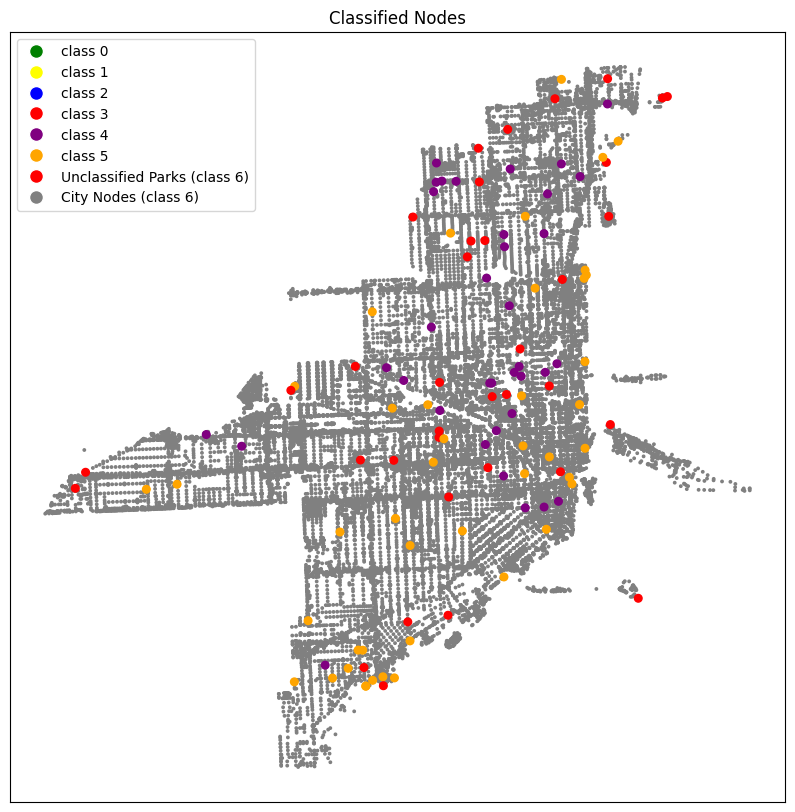

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Ensure 'nearest_street_node' is correctly set as the index
if 'nearest_street_node' in comparison_gdf.columns:
    comparison_gdf.set_index('nearest_street_node', inplace=True)
else:
    print("Error: 'nearest_street_node' column is missing.")

# Convert node_class to integer if it's not already
comparison_gdf['node_class'] = comparison_gdf['node_class'].astype(int)

# Classify the nodes
for node in G.nodes:
    if node in comparison_gdf.index:
        node_class = comparison_gdf.at[node, 'node_class']
        if isinstance(node_class, pd.Series):
            node_class = node_class.iloc[0]
        G.nodes[node]['node_class'] = int(node_class)
    else:
        G.nodes[node]['node_class'] = 6  # Default to class 6 for unclassified nodes

# Extract node classes
node_classes = pd.Series(nx.get_node_attributes(G, 'node_class'))
print("Node classifications (sample):")
print(node_classes.head())

# Count the number of nodes in each class
node_class_counts = node_classes.value_counts().sort_index()
print("\nNumber of nodes in each class:")
print(node_class_counts)

# Plot classified nodes
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Classified Nodes')

# Define colors for node classes
node_color_map = {0: "green", 1: "yellow", 2: "blue", 3: "red", 4: "purple", 5: "orange", 6: "gray"}
node_colors = [node_color_map[G.nodes[node]['node_class']] for node in G.nodes]

# Define node sizes, with city nodes being smaller
node_sizes = [3 if G.nodes[node]['node_class'] == 6 else 20 for node in G.nodes]

# Define positions for nodes
positions = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes}

# Plot nodes
nx.draw_networkx_nodes(G, pos=positions, node_color=node_colors, node_size=node_sizes, ax=ax)

# Highlight park nodes
park_nodes = comparison_gdf[comparison_gdf['park_geometry'].notnull()]
park_node_colors = []
for node in park_nodes.index:
    if node in G.nodes:
        if G.nodes[node]['node_class'] == 6:
            park_node_colors.append('red')
        else:
            park_node_colors.append(node_color_map[G.nodes[node]['node_class']])
nx.draw_networkx_nodes(G, pos=positions, nodelist=park_nodes.index.tolist(), node_color=park_node_colors, node_size=30, ax=ax, label='Park Nodes')

# Add legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'class {cls}')
    for cls, color in node_color_map.items() if cls != 6
]
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Unclassified Parks (class 6)'))
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='City Nodes (class 6)'))
ax.legend(handles=handles)

plt.show()

# Reset index to include 'nearest_street_node' in the columns
comparison_gdf.reset_index(inplace=True)


In [ ]:
# prompt: remove duplicates in nearest_street_node keep the first one. shopw me the count in the end

# Remove duplicates in 'nearest_street_node' and keep the first one
comparison_gdf = comparison_gdf.drop_duplicates(subset='nearest_street_node', keep='first')

# Show the count
print(f"Number of rows after removing duplicates: {len(comparison_gdf)}")


Number of rows after removing duplicates: 115


### 2.3: Nodes & Buffers

In [ ]:
print("Comparison GDF columns:", comparison_gdf.columns)

Comparison GDF columns: Index(['nearest_street_node', 'park_geometry', 'B_geometry', 'buffer',
       'B_avgScore', 'park_totalAcreage', 'park_numFeatures',
       'park_reviewsCount', 'park_avgScore', 'NAME', 'osm_id', 'node_class',
       'class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5',
       'class_6', 'park_coords', 'B_coords', 'buffer_coords',
       'B_avgScore_norm', 'park_totalAcreage_norm', 'park_numFeatures_norm',
       'park_reviewsCount_norm'],
      dtype='object')


Number of buffers created: 115


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-20-d2f6ec35e3d7>:29: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  park_buffers['geometry'] = park_nodes.index.to_series().apply(lambda node: Point(G.nodes[node]['x'], G.nodes[node]['y']).buffer(833))


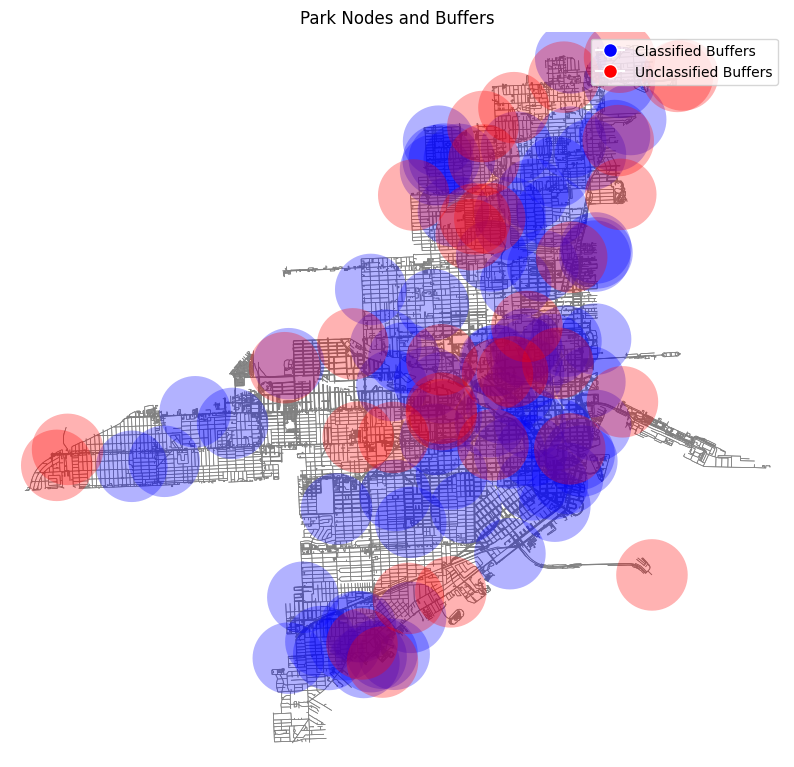

In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Ensure 'nearest_street_node' is correctly set as the index and nodes are classified
comparison_gdf.set_index('nearest_street_node', inplace=True)
comparison_gdf['node_class'] = comparison_gdf['node_class'].astype(int)

# Classify the nodes
for node in G.nodes:
    if node in comparison_gdf.index:
        node_class = comparison_gdf.at[node, 'node_class']
        if isinstance(node_class, pd.Series):
            node_class = node_class.iloc[0]
        G.nodes[node]['node_class'] = int(node_class)
    else:
        G.nodes[node]['node_class'] = 6  # Default to class 6 for unclassified nodes

# Extract node classes
node_classes = pd.Series(nx.get_node_attributes(G, 'node_class'))

# Filter for park nodes only
park_nodes = comparison_gdf[comparison_gdf['park_geometry'].notnull()]

# Visualize nodes, buffers, and unclassified edges
park_buffers = gpd.GeoDataFrame({'node_class': park_nodes['node_class']})
park_buffers['geometry'] = park_nodes.index.to_series().apply(lambda node: Point(G.nodes[node]['x'], G.nodes[node]['y']).buffer(833))
park_buffers = gpd.GeoDataFrame(park_buffers, geometry='geometry')

# Count the number of buffers created
num_buffers = park_buffers.shape[0]
print(f"Number of buffers created: {num_buffers}")

# Separate buffers into classified and unclassified (class 6)
classified_buffers = park_buffers[park_buffers['node_class'] != 6]
unclassified_buffers = park_buffers[park_buffers['node_class'] == 6]

# Plot the graph without edge directions
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G, ax=ax, node_size=0, edge_color='grey', edge_linewidth=0.5, show=False, close=False)

# Plot classified and unclassified buffers
classified_buffers.plot(ax=ax, color='blue', alpha=0.3, edgecolor='none', label='Classified Buffers')
unclassified_buffers.plot(ax=ax, color='red', alpha=0.3, edgecolor='none', label='Unclassified Buffers')

# Add scales and labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Park Nodes and Buffers')

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Classified Buffers'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Unclassified Buffers')
]
ax.legend(handles=handles)

plt.show()

# Reset index to include 'nearest_street_node' in the columns
comparison_gdf.reset_index(inplace=True)


### 2.4: Edge Classifcation

In [ ]:
print("Comparison GDF columns:", comparison_gdf.columns)

Comparison GDF columns: Index(['nearest_street_node', 'park_geometry', 'B_geometry', 'buffer',
       'B_avgScore', 'park_totalAcreage', 'park_numFeatures',
       'park_reviewsCount', 'park_avgScore', 'NAME', 'osm_id', 'node_class',
       'class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5',
       'class_6', 'park_coords', 'B_coords', 'buffer_coords',
       'B_avgScore_norm', 'park_totalAcreage_norm', 'park_numFeatures_norm',
       'park_reviewsCount_norm'],
      dtype='object')


Logic for Edge Classification:

**Create Buffers:**

Create buffers around each park node. These buffers will have a fixed radius (e.g., 833 units) and will represent the area of influence of each park.
Check Edge Endpoints:

For each edge in the graph, check the coordinates of both endpoints (u, v).
Determine if either of the endpoints falls within any of the park node buffers.
Assign

**Edge Class:**

If both endpoints of an edge fall within different buffers, calculate the distance from each endpoint to the centers of the buffers they fall within.
Assign the edge to the class of the closest park buffer based on the minimum distance to either endpoint.
If only one endpoint falls within a buffer, assign the edge to the class of that buffer.
If neither endpoint falls within any buffer, assign the edge to class 6 (unclassified).

**Edge Classification Priority:**

If an edge falls within multiple buffers, use the closest park buffer's class for the edge classification.


<ipython-input-22-24098fa7045b>:28: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  park_buffers['geometry'] = park_nodes['nearest_street_node'].apply(lambda node: Point(G.nodes[node]['x'], G.nodes[node]['y']).buffer(833))


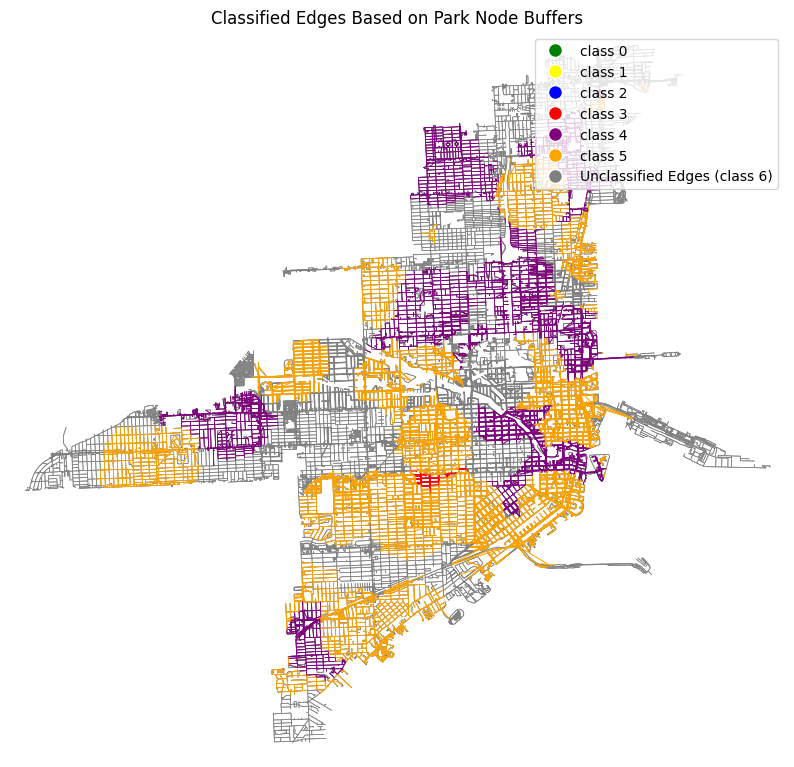

In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt

# Ensure the 'nearest_street_node' column is present and nodes are classified
comparison_gdf.set_index('nearest_street_node', inplace=True)
comparison_gdf['node_class'] = comparison_gdf['node_class'].astype(int)

for node in G.nodes:
    if node in comparison_gdf.index:
        node_class = comparison_gdf.at[node, 'node_class']
        if isinstance(node_class, pd.Series):
            node_class = node_class.iloc[0]
        G.nodes[node]['node_class'] = int(node_class)
    else:
        G.nodes[node]['node_class'] = 6

node_classes = pd.Series(nx.get_node_attributes(G, 'node_class'))

# Restore nearest_street_node column
comparison_gdf.reset_index(inplace=True)

# Create Buffers Around Park Nodes
park_nodes = comparison_gdf[comparison_gdf['park_geometry'].notnull()]
park_buffers = gpd.GeoDataFrame({'node_class': park_nodes['node_class']})
park_buffers['geometry'] = park_nodes['nearest_street_node'].apply(lambda node: Point(G.nodes[node]['x'], G.nodes[node]['y']).buffer(833))
park_buffers.set_geometry('geometry', inplace=True)

# Function to classify edges based on node buffers
def classify_edges_by_buffers(G, node_buffers):
    is_multigraph = isinstance(G, nx.MultiGraph)

    for edge in G.edges(data=True, keys=is_multigraph):
        if is_multigraph:
            u, v, key, data = edge
        else:
            u, v, data = edge

        u_point = Point(G.nodes[u]['x'], G.nodes[u]['y'])
        v_point = Point(G.nodes[v]['x'], G.nodes[v]['y'])

        edge_class = 6
        min_distance = float('inf')

        for idx, buffer in node_buffers.iterrows():
            if buffer['geometry'].contains(u_point) or buffer['geometry'].contains(v_point):
                node_class = buffer['node_class']
                distance = min(buffer['geometry'].distance(u_point), buffer['geometry'].distance(v_point))
                if distance < min_distance:
                    min_distance = distance
                    edge_class = node_class

        if is_multigraph:
            G.edges[u, v, key]['edge_class'] = edge_class
        else:
            G.edges[u, v]['edge_class'] = edge_class

# Apply the classification logic
classify_edges_by_buffers(G, park_buffers)

# Extract Edge Classes for Plotting
edges_list = []
is_multigraph = isinstance(G, nx.MultiGraph)
for edge in G.edges(data=True, keys=is_multigraph):
    if is_multigraph:
        u, v, key, data = edge
    else:
        u, v, data = edge

    if data['edge_class'] != 6:
        line = LineString([(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])])
        edges_list.append({'geometry': line, 'edge_class': data['edge_class']})

edges_gdf = gpd.GeoDataFrame(edges_list, geometry='geometry', crs=G.graph['crs'])

# Plot the graph with classified edges and buffers
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G, ax=ax, node_size=0, edge_color='grey', edge_linewidth=0.5, show=False, close=False)

# Plot classified edges
edge_color_map = {0: "green", 1: "yellow", 2: "blue", 3: "red", 4: "purple", 5: "orange", 6: "grey"}
edge_colors = [edge_color_map[edge_class] for edge_class in edges_gdf['edge_class']]
edges_gdf.plot(ax=ax, linewidth=0.5, edgecolor=edge_colors)

# Add scales and labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Classified Edges Based on Park Node Buffers')

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'class {cls}')
    for cls, color in edge_color_map.items() if cls != 6
]
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label='Unclassified Edges (class 6)'))
ax.legend(handles=handles)

plt.show()


In [ ]:
# Count the number of edges in each class
edge_class_counts = edges_gdf['edge_class'].value_counts().sort_index()
print("Number of edges in each class:")
print(edge_class_counts)

# Check how many edges fall within the buffer zones
buffer_edges = edges_gdf[edges_gdf['edge_class'] != 6]
buffer_edge_count = buffer_edges.shape[0]
print(f"\nNumber of edges that fall within buffer zones: {buffer_edge_count}")

# Total number of edges
total_edges_count = edges_gdf.shape[0]
print(f"Total number of edges: {total_edges_count}")

# Number of edges outside buffer zones
outside_buffer_edge_count = total_edges_count - buffer_edge_count
print(f"Number of edges outside buffer zones: {outside_buffer_edge_count}")


Number of edges in each class:
edge_class
3      708
4    23534
5    45884
Name: count, dtype: int64

Number of edges that fall within buffer zones: 70126
Total number of edges: 70126
Number of edges outside buffer zones: 0


<ipython-input-24-8b11c2756a13>:15: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  park_buffers['geometry'] = park_nodes['nearest_street_node'].apply(lambda node: Point(G.nodes[node]['x'], G.nodes[node]['y']).buffer(833))


Number of edges in each class:
edge_class
3      708
4    23534
5    45884
6    37470
Name: count, dtype: int64

Number of edges that fall within buffer zones: 95026
Total number of edges: 107596
Number of edges outside buffer zones: 12570


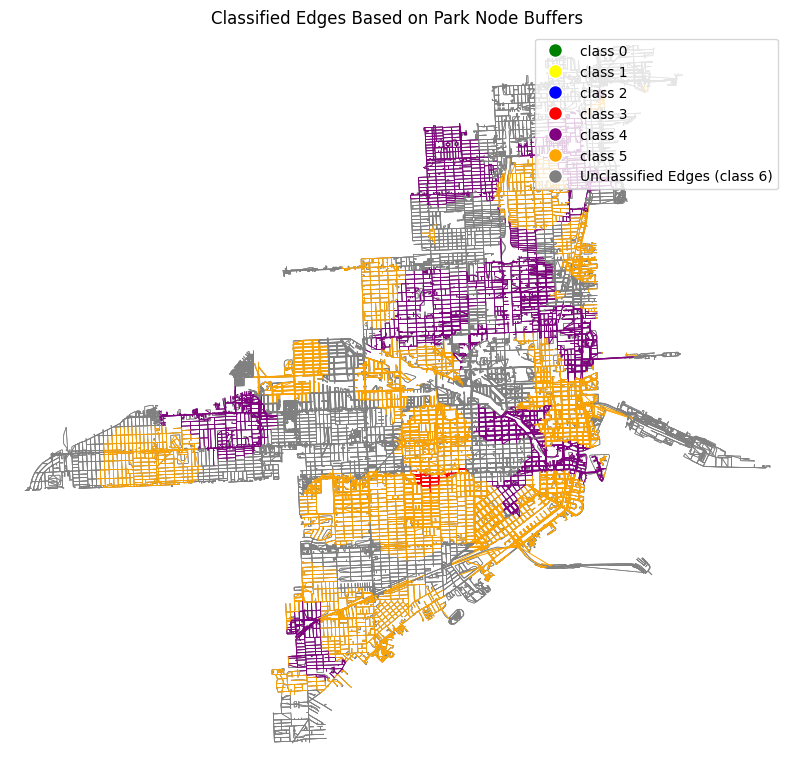

In [ ]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt

# Ensure the 'nearest_street_node' column is present and nodes are classified
comparison_gdf.set_index('nearest_street_node', inplace=True)
comparison_gdf['node_class'] = comparison_gdf['node_class'].astype(int)

# Restore nearest_street_node column
comparison_gdf.reset_index(inplace=True)

# Create Buffers Around Park Nodes
park_nodes = comparison_gdf[comparison_gdf['park_geometry'].notnull()]
park_buffers = gpd.GeoDataFrame({'node_class': park_nodes['node_class']})
park_buffers['geometry'] = park_nodes['nearest_street_node'].apply(lambda node: Point(G.nodes[node]['x'], G.nodes[node]['y']).buffer(833))
park_buffers.set_geometry('geometry', inplace=True)

# Extract Edge Classes for Plotting
edges_list = []
is_multigraph = isinstance(G, nx.MultiGraph)
for edge in G.edges(data=True, keys=is_multigraph):
    if is_multigraph:
        u, v, key, data = edge
    else:
        u, v, data = edge

    line = LineString([(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])])
    edges_list.append({'geometry': line, 'edge_class': data['edge_class']})

edges_gdf = gpd.GeoDataFrame(edges_list, geometry='geometry', crs=G.graph['crs'])

# Count the number of edges in each class
edge_class_counts = edges_gdf['edge_class'].value_counts().sort_index()
print("Number of edges in each class:")
print(edge_class_counts)

# Check how many edges fall within the buffer zones
buffer_edges = edges_gdf[edges_gdf.intersects(park_buffers.unary_union)]
buffer_edge_count = buffer_edges.shape[0]
print(f"\nNumber of edges that fall within buffer zones: {buffer_edge_count}")

# Total number of edges
total_edges_count = edges_gdf.shape[0]
print(f"Total number of edges: {total_edges_count}")

# Number of edges outside buffer zones
outside_buffer_edge_count = total_edges_count - buffer_edge_count
print(f"Number of edges outside buffer zones: {outside_buffer_edge_count}")

# Plot the graph with classified edges and buffers
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G, ax=ax, node_size=0, edge_color='grey', edge_linewidth=0.5, show=False, close=False)

# Plot classified edges
edge_color_map = {0: "green", 1: "yellow", 2: "blue", 3: "red", 4: "purple", 5: "orange", 6: "grey"}
edge_colors = [edge_color_map[edge_class] for edge_class in edges_gdf['edge_class']]
edges_gdf.plot(ax=ax, linewidth=0.5, edgecolor=edge_colors)

# Add scales and labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Classified Edges Based on Park Node Buffers')

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'class {cls}')
    for cls, color in edge_color_map.items() if cls != 6
]
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label='Unclassified Edges (class 6)'))
ax.legend(handles=handles)

plt.show()


## 3: Convert NetworkX Graph to DGL Graph

In this step, we convert the NetworkX graph to a DGL graph, making sure that we include the correct node attributes and edge attributes.

**Node Attributes:**

total_acreage: Represents the total acreage of each park.

num_features: Represents the number of features in each park.

reviews_count: Represents the number of reviews each park has.

avg_score: Represents the average score of each park.

x and y: Coordinates of the nodes.

**Edge Attributes:**

edge_class: Classification of the edges based on the buffer zones.

mask: Splitting masks for training, validation, testing, and prediction.

In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
import pandas as pd
import dgl
import torch
from sklearn.model_selection import train_test_split


### 3.1: Identify Park Nodes and Relevant Edges

In [ ]:
# Identify park nodes
park_nodes = comparison_gdf['nearest_street_node'].unique()

# Identify relevant edges (those that fall within park buffers)
relevant_edges = []
for u, v, data in G.edges(data=True):
    if u in park_nodes or v in park_nodes:
        relevant_edges.append((u, v))


### 3.2: Filter the Graph


In [ ]:
# Create subgraph with park nodes and relevant edges
is_multigraph = isinstance(G, nx.MultiGraph)

if is_multigraph:
    relevant_edges_multigraph = [(u, v, k) for u, v, k in G.edges(keys=True) if (u, v) in relevant_edges]
    subgraph = G.edge_subgraph(relevant_edges_multigraph).copy()
else:
    subgraph = G.edge_subgraph(relevant_edges).copy()

# Ensure we include all park nodes in the subgraph
subgraph.add_nodes_from(park_nodes)

# Assign default values to city nodes based on the park nodes in whose buffer zones they fall
for node in subgraph.nodes:
    if node in comparison_gdf['nearest_street_node'].values:
        subgraph.nodes[node]['park_totalAcreage_norm'] = comparison_gdf.loc[comparison_gdf['nearest_street_node'] == node, 'park_totalAcreage_norm'].values[0]
        subgraph.nodes[node]['park_numFeatures_norm'] = comparison_gdf.loc[comparison_gdf['nearest_street_node'] == node, 'park_numFeatures_norm'].values[0]
        subgraph.nodes[node]['park_reviewsCount_norm'] = comparison_gdf.loc[comparison_gdf['nearest_street_node'] == node, 'park_reviewsCount_norm'].values[0]
        subgraph.nodes[node]['B_avgScore_norm'] = comparison_gdf.loc[comparison_gdf['nearest_street_node'] == node, 'B_avgScore_norm'].values[0]
    else:
        # Find the nearest park buffer and assign its values
        min_distance = float('inf')
        nearest_park_values = None
        node_point = Point(G.nodes[node]['x'], G.nodes[node]['y'])
        for idx, buffer in park_buffers.iterrows():
            distance = buffer['geometry'].distance(node_point)
            if distance < min_distance:
                min_distance = distance
                nearest_park_values = {
                    'park_totalAcreage_norm': buffer['node_class'],
                    'park_numFeatures_norm': buffer['node_class'],
                    'park_reviewsCount_norm': buffer['node_class'],
                    'B_avgScore_norm': buffer['node_class']
                }
        if nearest_park_values:
            subgraph.nodes[node]['park_totalAcreage_norm'] = nearest_park_values['park_totalAcreage_norm']
            subgraph.nodes[node]['park_numFeatures_norm'] = nearest_park_values['park_numFeatures_norm']
            subgraph.nodes[node]['park_reviewsCount_norm'] = nearest_park_values['park_reviewsCount_norm']
            subgraph.nodes[node]['B_avgScore_norm'] = nearest_park_values['B_avgScore_norm']

# Verify that the node attributes are set correctly
missing_attributes = [node for node in subgraph.nodes if 'park_totalAcreage_norm' not in subgraph.nodes[node]]
print(f"Nodes without 'park_totalAcreage_norm' attribute after assigning default values: {missing_attributes}")
print(f"Number of nodes without 'park_totalAcreage_norm' attribute: {len(missing_attributes)}")


Nodes without 'park_totalAcreage_norm' attribute after assigning default values: []
Number of nodes without 'park_totalAcreage_norm' attribute: 0


### 3.3: Set Attributes for Park Nodes

In [ ]:
# Initialize dictionaries for node attributes
dic_total_acreage = {}
dic_num_features = {}
dic_reviews_count = {}
dic_avg_score = {}

# Set attributes for park nodes
for node in subgraph.nodes:
    if node in comparison_gdf['nearest_street_node'].values:
        dic_total_acreage[node] = comparison_gdf.loc[comparison_gdf['nearest_street_node'] == node, 'park_totalAcreage_norm'].values[0]
        dic_num_features[node] = comparison_gdf.loc[comparison_gdf['nearest_street_node'] == node, 'park_numFeatures_norm'].values[0]
        dic_reviews_count[node] = comparison_gdf.loc[comparison_gdf['nearest_street_node'] == node, 'park_reviewsCount_norm'].values[0]
        dic_avg_score[node] = comparison_gdf.loc[comparison_gdf['nearest_street_node'] == node, 'B_avgScore_norm'].values[0]

nx.set_node_attributes(subgraph, dic_total_acreage, 'park_totalAcreage_norm')
nx.set_node_attributes(subgraph, dic_num_features, 'park_numFeatures_norm')
nx.set_node_attributes(subgraph, dic_reviews_count, 'park_reviewsCount_norm')
nx.set_node_attributes(subgraph, dic_avg_score, 'B_avgScore_norm')

# Verify that all attributes have been set
for node, data in subgraph.nodes(data=True):
    if 'park_totalAcreage_norm' not in data:
        print(f"Node {node} is missing 'park_totalAcreage_norm'")
    if 'park_numFeatures_norm' not in data:
        print(f"Node {node} is missing 'park_numFeatures_norm'")
    if 'park_reviewsCount_norm' not in data:
        print(f"Node {node} is missing 'park_reviewsCount_norm'")
    if 'B_avgScore_norm' not in data:
        print(f"Node {node} is missing 'B_avgScore_norm'")


### 3.4: Initiating Masks  for Training, Validation, Testing and Prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensure 'edges' DataFrame is defined and available
if 'edges' not in locals():
    edges = pd.DataFrame([
        (u, v, data) for u, v, data in G.edges(data=True)
    ], columns=['u', 'v', 'data'])

# Initialize masks
edges['mask'] = -1

# Identify labeled and unlabeled edges
edges['edge_class'] = edges['data'].apply(lambda x: x['edge_class'])
labeled_edges = [i for i, j in zip(list(edges.index), edges["edge_class"]) if j != 6]
unlabeled_edges = [i for i, j in zip(list(edges.index), edges["edge_class"]) if j == 6]

print("Number of labeled edges:", len(labeled_edges))
print("Number of unlabeled edges:", len(unlabeled_edges))

# Split labeled edges into training, validation, and test sets
train_edges, test_edges = train_test_split(labeled_edges, random_state=1, test_size=0.1)
train_edges, validation_edges = train_test_split(train_edges, random_state=1, test_size=0.11)

prediction_edges = unlabeled_edges

print("Number of training edges:", len(train_edges))
print("Number of validation edges:", len(validation_edges))
print("Number of test edges:", len(test_edges))
print("Number of prediction edges:", len(prediction_edges))

# Set mask values
for ind in train_edges:
    edges.at[ind, "mask"] = 0
for ind in validation_edges:
    edges.at[ind, "mask"] = 1
for ind in test_edges:
    edges.at[ind, "mask"] = 2
for ind in prediction_edges:
    edges.at[ind, "mask"] = 3

# Ensure edges DataFrame index is tuples of (u, v) for non-multigraphs and (u, v, key) for multigraphs
if G.is_multigraph():
    edges.index = pd.MultiIndex.from_tuples([(u, v, k) for u, v, k, data in G.edges(data=True, keys=True)])
else:
    edges.index = pd.MultiIndex.from_tuples([(u, v) for u, v, data in G.edges(data=True)])

# Set edge mask attributes in the graph
dic_edge_masks = {}
if G.is_multigraph():
    for u, v, key, data in G.edges(data=True, keys=True):
        dic_edge_masks[(u, v, key)] = edges.loc[(u, v, key), 'mask']
else:
    for u, v, data in G.edges(data=True):
        dic_edge_masks[(u, v)] = edges.loc[(u, v), 'mask']

nx.set_edge_attributes(G, dic_edge_masks, 'mask')

# Ensure the mask attributes are transferred to the subgraph
relevant_edges = [(u, v) if not G.is_multigraph() else (u, v, key) for u, v, key in edges.index]

if G.is_multigraph():
    subgraph = G.edge_subgraph(relevant_edges).copy()
else:
    subgraph = G.edge_subgraph(relevant_edges).copy()


Number of labeled edges: 70126
Number of unlabeled edges: 37470
Number of training edges: 56170
Number of validation edges: 6943
Number of test edges: 7013
Number of prediction edges: 37470


### 3.5: Set Edge Attributes

In [ ]:
# Initialize edge attributes
dic_edge_class = {}
dic_edge_masks = {}
if subgraph.is_multigraph():
    for u, v, key, data in subgraph.edges(data=True, keys=True):
        dic_edge_class[(u, v, key)] = data['edge_class']
        dic_edge_masks[(u, v, key)] = data.get('mask', -1)  # Default to -1 if mask is missing
else:
    for u, v, data in subgraph.edges(data=True):
        dic_edge_class[(u, v)] = data['edge_class']
        dic_edge_masks[(u, v)] = data.get('mask', -1)  # Default to -1 if mask is missing

nx.set_edge_attributes(subgraph, dic_edge_class, 'edge_class')
nx.set_edge_attributes(subgraph, dic_edge_masks, 'mask')


### 3.6: Create DGL Graph

In [ ]:
import dgl
import torch

# Define node and edge attributes to include in the DGL graph
node_attributes_list = ['park_totalAcreage_norm', 'park_numFeatures_norm', 'park_reviewsCount_norm', 'B_avgScore_norm', 'x', 'y', 'node_class', 'gdf_order']
edge_attributes_list = ['edge_class', 'mask']

# Initialize default values for node attributes
default_values = {
    'park_totalAcreage_norm': 0.0,
    'park_numFeatures_norm': 0.0,
    'park_reviewsCount_norm': 0.0,
    'B_avgScore_norm': 0.0,
    'x': 0.0,
    'y': 0.0,
    'node_class': 6,  # Assuming 6 is the class for unknown nodes
    'gdf_order': 0
}

# Ensure node attributes are scalar values and set default values if missing
for node in subgraph.nodes(data=True):
    for attr in node_attributes_list:
        if attr not in subgraph.nodes[node[0]]:
            subgraph.nodes[node[0]][attr] = default_values[attr]
        elif isinstance(subgraph.nodes[node[0]][attr], pd.Series):
            subgraph.nodes[node[0]][attr] = subgraph.nodes[node[0]][attr].values[0]
        elif isinstance(subgraph.nodes[node[0]][attr], np.ndarray):
            subgraph.nodes[node[0]][attr] = subgraph.nodes[node[0]][attr].item()

# Ensure edge attributes are scalar values and reassign edge masks
for u, v, data in subgraph.edges(data=True):
    for attr in edge_attributes_list:
        if isinstance(data.get(attr), pd.Series):
            data[attr] = data[attr].values[0]
        elif isinstance(data.get(attr), np.ndarray):
            data[attr] = data[attr].item()

# Convert NetworkX graph to DGL graph
graph = dgl.from_networkx(subgraph, node_attrs=node_attributes_list, edge_attrs=edge_attributes_list)

print(f"Number of nodes in DGL graph: {graph.number_of_nodes()}")

# Prepare node features tensor
features = ['park_totalAcreage_norm', 'park_numFeatures_norm', 'park_reviewsCount_norm', 'B_avgScore_norm']
for feature in features:
    graph.ndata[feature] = torch.reshape(graph.ndata[feature], (graph.ndata[feature].shape[0], 1))

graph.ndata['feat'] = torch.cat([graph.ndata[feature] for feature in features], 1)
graph.ndata['feat'] = graph.ndata['feat'].type(torch.float32)

print(f"Graph number of edges: {subgraph.number_of_edges()}")
print(f"DGL graph number of edges: {graph.num_edges()}")

# Add 'gdf_order' attribute to nodes
for idx, node in enumerate(subgraph.nodes):
    subgraph.nodes[node]['gdf_order'] = idx

print("Number of nodes in DGL graph:", graph.number_of_nodes())
print("Graph number of edges:", subgraph.number_of_edges())
print("DGL graph number of edges:", graph.num_edges())

# Verify masks
print("Edge masks:", graph.edata['mask'])
print("Edge classes:", graph.edata['edge_class'])

# Verify that masks are correctly assigned
check_ind = 234  # Example index for checking masks
print(f"Train mask for index {check_ind}: {graph.edata['mask'][check_ind] == 0}")
print(f"Validation mask for index {check_ind}: {graph.edata['mask'][check_ind] == 1}")
print (f"Test mask for index {check_ind}: {graph.edata['mask'][check_ind] == 2}")
print(f"Prediction mask for index {check_ind}: {graph.edata['mask'][check_ind] == 3}")


Number of nodes in DGL graph: 35383
Graph number of edges: 107596
DGL graph number of edges: 107596
Number of nodes in DGL graph: 35383
Graph number of edges: 107596
DGL graph number of edges: 107596
Edge masks: tensor([0, 0, 0,  ..., 3, 3, 0])
Edge classes: tensor([5, 5, 5,  ..., 6, 6, 5])
Train mask for index 234: True
Validation mask for index 234: False
Test mask for index 234: False
Prediction mask for index 234: False


# 4: Prepare the Graph for a Transductive Edge Classification Task

### 4.1: Correct Mask Assignment and Visualization in NetworkX

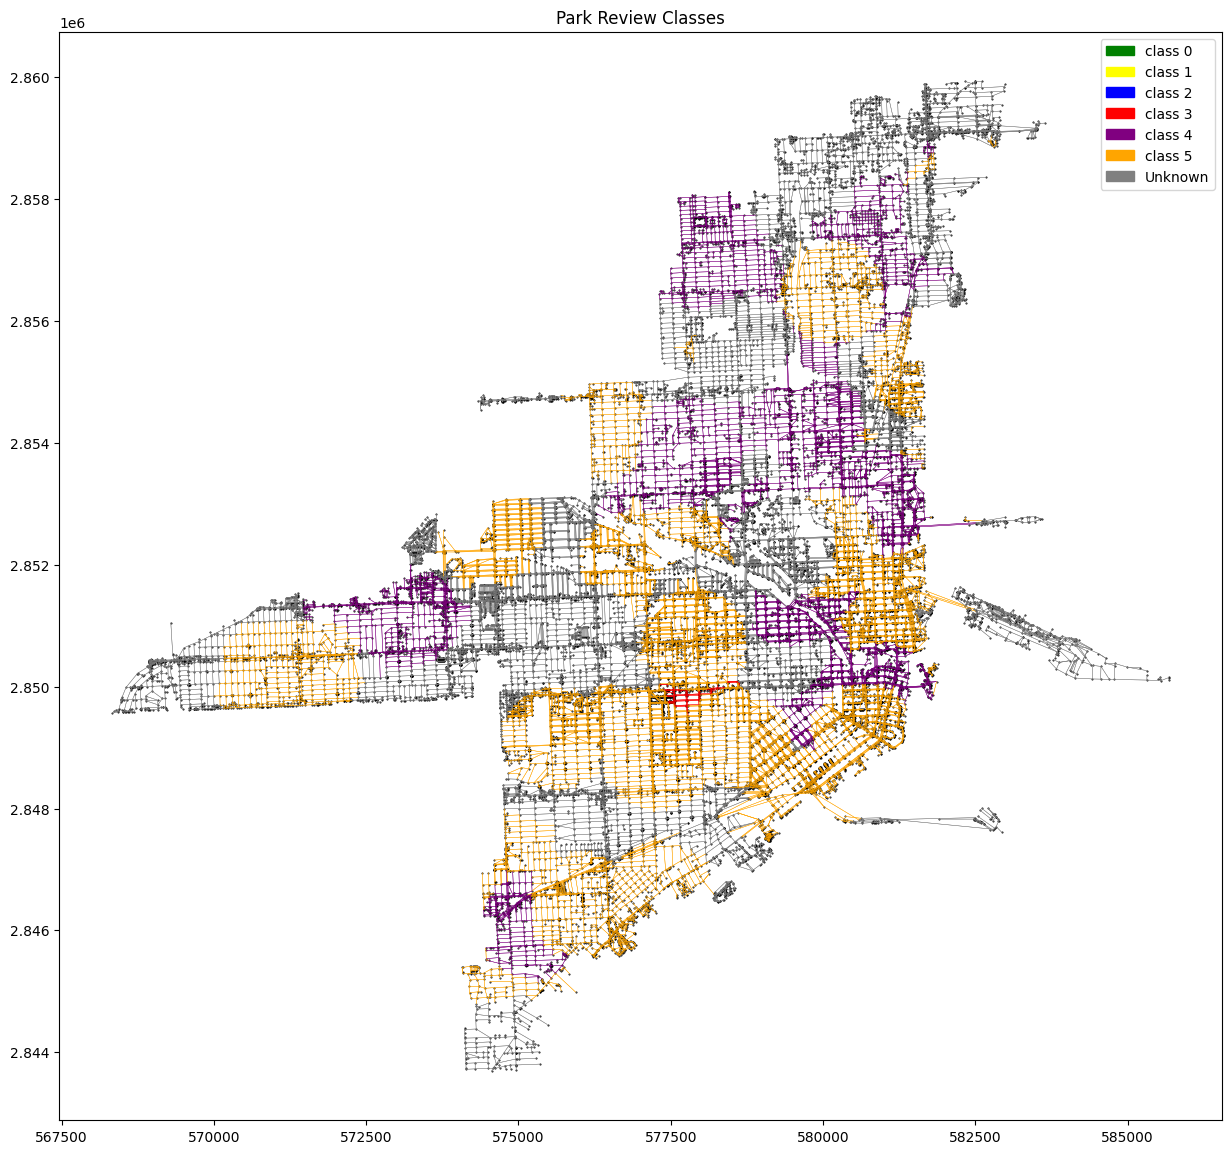

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
from shapely.geometry import Point, LineString

# Create GeoDataFrame for nodes
node_coords = [(subgraph.nodes[node]['x'], subgraph.nodes[node]['y']) for node in subgraph.nodes]
node_gdf = gpd.GeoDataFrame({'geometry': [Point(xy) for xy in node_coords]})

# Create GeoDataFrame for edges
edge_geoms = []
edge_classes = []
for edge in subgraph.edges(keys=True) if isinstance(subgraph, nx.MultiGraph) else subgraph.edges:
    u, v = edge[:2]
    edge_geoms.append(LineString([(subgraph.nodes[u]['x'], subgraph.nodes[u]['y']),
                                  (subgraph.nodes[v]['x'], subgraph.nodes[v]['y'])]))
    edge_classes.append(subgraph.edges[edge]['edge_class'])

edge_gdf = gpd.GeoDataFrame({'geometry': edge_geoms, 'class': edge_classes})

# Plotting
fig, ax = plt.subplots(figsize=(15, 15))
node_gdf.plot(ax=ax, markersize=0.2, color="black")
he_colors_dict = {0: "green", 1: "yellow", 2: "blue", 3: "red", 4: "purple", 5: "orange", 6: "grey"}
he_colors = [he_colors_dict[i] for i in edge_gdf["class"]]
edge_gdf.plot(ax=ax, color=he_colors, linewidth=0.3)
ax.set_title('Park Review Classes')

# Create a legend
c0 = mpatches.Patch(color=he_colors_dict[0], label='class 0')
c1 = mpatches.Patch(color=he_colors_dict[1], label='class 1')
c2 = mpatches.Patch(color=he_colors_dict[2], label='class 2')
c3 = mpatches.Patch(color=he_colors_dict[3], label='class 3')
c4 = mpatches.Patch(color=he_colors_dict[4], label='class 4')
c5 = mpatches.Patch(color=he_colors_dict[5], label='class 5')
c6 = mpatches.Patch(color=he_colors_dict[6], label='Unknown')

plt.legend(handles=[c0, c1, c2, c3, c4, c5, c6])
plt.show()

# Prepare the graph for a transductive edge classification task
train_mask = (graph.edata['mask'] == 0)
validation_mask = (graph.edata['mask'] == 1)
test_mask = (graph.edata['mask'] == 2)
prediction_mask = (graph.edata['mask'] == 3)

# Reorder dictionaries for debugging
reorder_dict = {i: j for i, j in enumerate([o.item() for o in graph.ndata['gdf_order']])}
osmnx_order_index = {i: j for i, j in enumerate(G.nodes)}
dgl_edge_order_index = {(i.item(), j.item()): dgl_ind for dgl_ind, (i, j) in enumerate(zip(graph.edges()[0], graph.edges()[1]))}

print(reorder_dict)
print(osmnx_order_index)
print(dgl_edge_order_index)

check_ind = 234  # Example index for checking masks
print(f"Train mask for index {check_ind}: {train_mask[check_ind]}")
print(f"Validation mask for index {check_ind}: {validation_mask[check_ind]}")
print(f"Test mask for index {check_ind}: {test_mask[check_ind]}")
print(f"Prediction mask for index {check_ind}: {prediction_mask[check_ind]}")


### 4.2: Convert NetworkX Graph to DGL Graph and Verify Masks

In [ ]:
import dgl
import torch

# Define node and edge attributes to include in the DGL graph
node_attributes_list = ['park_totalAcreage_norm', 'park_numFeatures_norm', 'park_reviewsCount_norm', 'B_avgScore_norm', 'x', 'y', 'node_class', 'gdf_order']
edge_attributes_list = ['edge_class', 'mask']

# Initialize default values for node attributes
default_values = {
    'park_totalAcreage_norm': 0.0,
    'park_numFeatures_norm': 0.0,
    'park_reviewsCount_norm': 0.0,
    'B_avgScore_norm': 0.0,
    'x': 0.0,
    'y': 0.0,
    'node_class': 6,  # Assuming 6 is the class for unknown nodes
    'gdf_order': 0
}

# Ensure node attributes are scalar values and set default values if missing
for node in subgraph.nodes(data=True):
    for attr in node_attributes_list:
        if attr not in subgraph.nodes[node[0]]:
            subgraph.nodes[node[0]][attr] = default_values[attr]
        elif isinstance(subgraph.nodes[node[0]][attr], pd.Series):
            subgraph.nodes[node[0]][attr] = subgraph.nodes[node[0]][attr].values[0]
        elif isinstance(subgraph.nodes[node[0]][attr], np.ndarray):
            subgraph.nodes[node[0]][attr] = subgraph.nodes[node[0]][attr].item()

# Ensure edge attributes are scalar values and reassign edge masks
for u, v, data in subgraph.edges(data=True):
    for attr in edge_attributes_list:
        if attr not in data:
            data[attr] = -1  # Default mask value
        elif isinstance(data.get(attr), pd.Series):
            data[attr] = data[attr].values[0]
        elif isinstance(data.get(attr), np.ndarray):
            data[attr] = data[attr].item()

# Convert NetworkX graph to DGL graph
graph = dgl.from_networkx(subgraph, node_attrs=node_attributes_list, edge_attrs=edge_attributes_list)

print(f"Number of nodes in DGL graph: {graph.number_of_nodes()}")

# Prepare node features tensor
features = ['park_totalAcreage_norm', 'park_numFeatures_norm', 'park_reviewsCount_norm', 'B_avgScore_norm']
for feature in features:
    graph.ndata[feature] = torch.reshape(graph.ndata[feature], (graph.ndata[feature].shape[0], 1))

graph.ndata['feat'] = torch.cat([graph.ndata[feature] for feature in features], 1)
graph.ndata['feat'] = graph.ndata['feat'].type(torch.float32)

print(f"Graph number of edges: {subgraph.number_of_edges()}")
print(f"DGL graph number of edges: {graph.num_edges()}")

# Verify masks
print("Edge masks:", graph.edata['mask'])
print("Edge classes:", graph.edata['edge_class'])

# Verify that masks are correctly assigned
check_ind = 234  # Example index for checking masks
print(f"Train mask for index {check_ind}: {graph.edata['mask'][check_ind] == 0}")
print(f"Validation mask for index {check_ind}: {graph.edata['mask'][check_ind] == 1}")
print(f"Test mask for index {check_ind}: {graph.edata['mask'][check_ind] == 2}")
print(f"Prediction mask for index {check_ind}: {graph.edata['mask'][check_ind] == 3}")


Number of nodes in DGL graph: 35383
Graph number of edges: 107596
DGL graph number of edges: 107596
Edge masks: tensor([0, 0, 0,  ..., 3, 3, 0])
Edge classes: tensor([5, 5, 5,  ..., 6, 6, 5])
Train mask for index 234: True
Validation mask for index 234: False
Test mask for index 234: False
Prediction mask for index 234: False


### 4.3: Visualize the Masks

edge_classes length: 107596, edge_geoms length: 107596


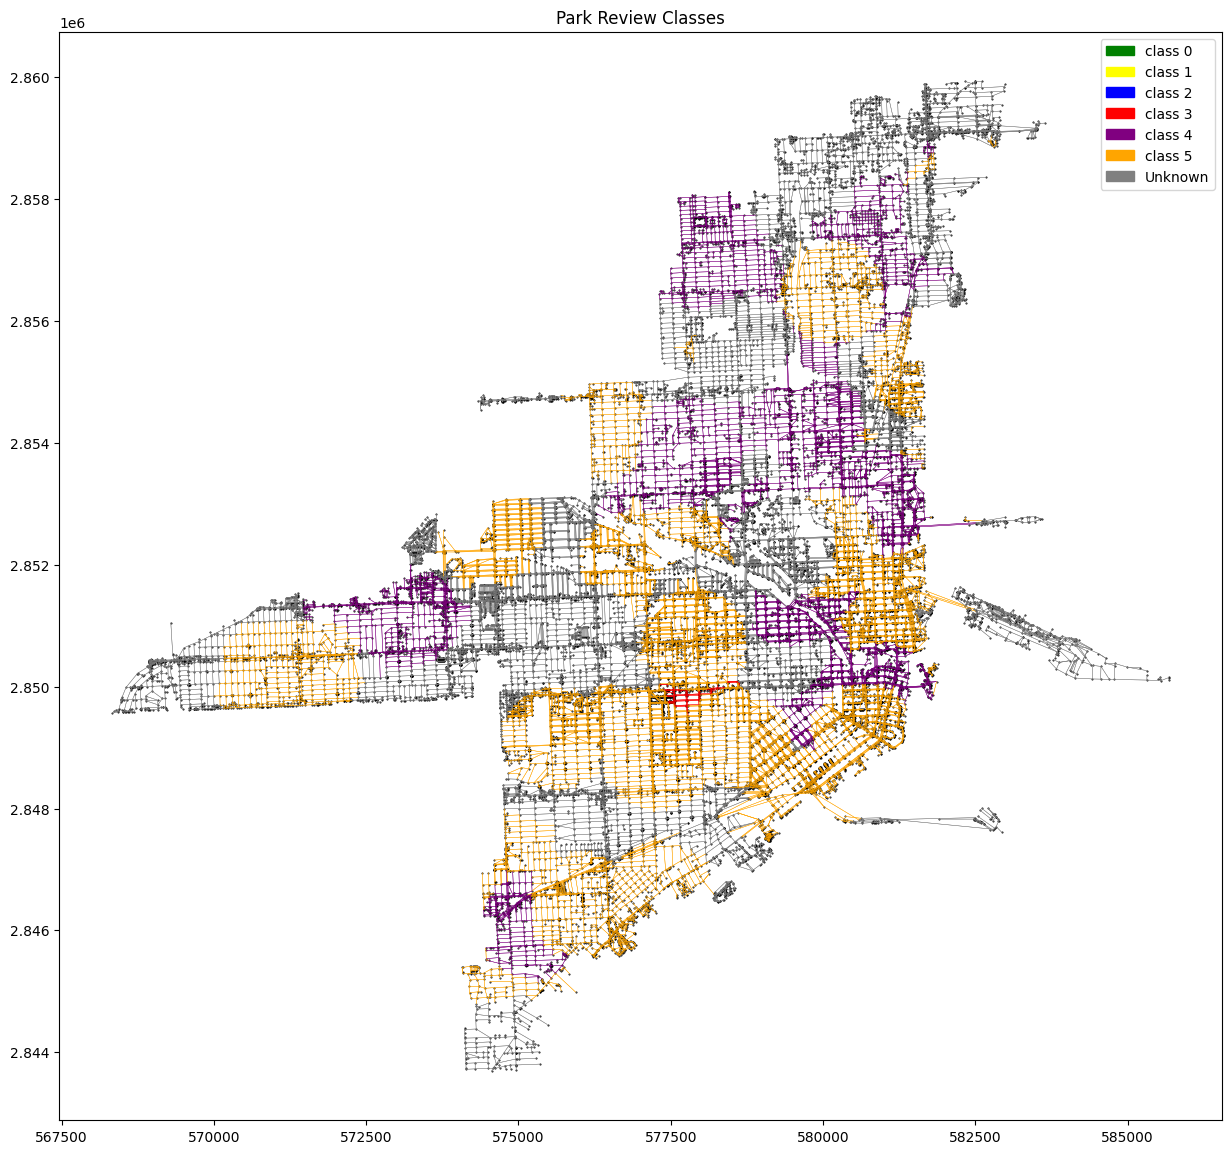

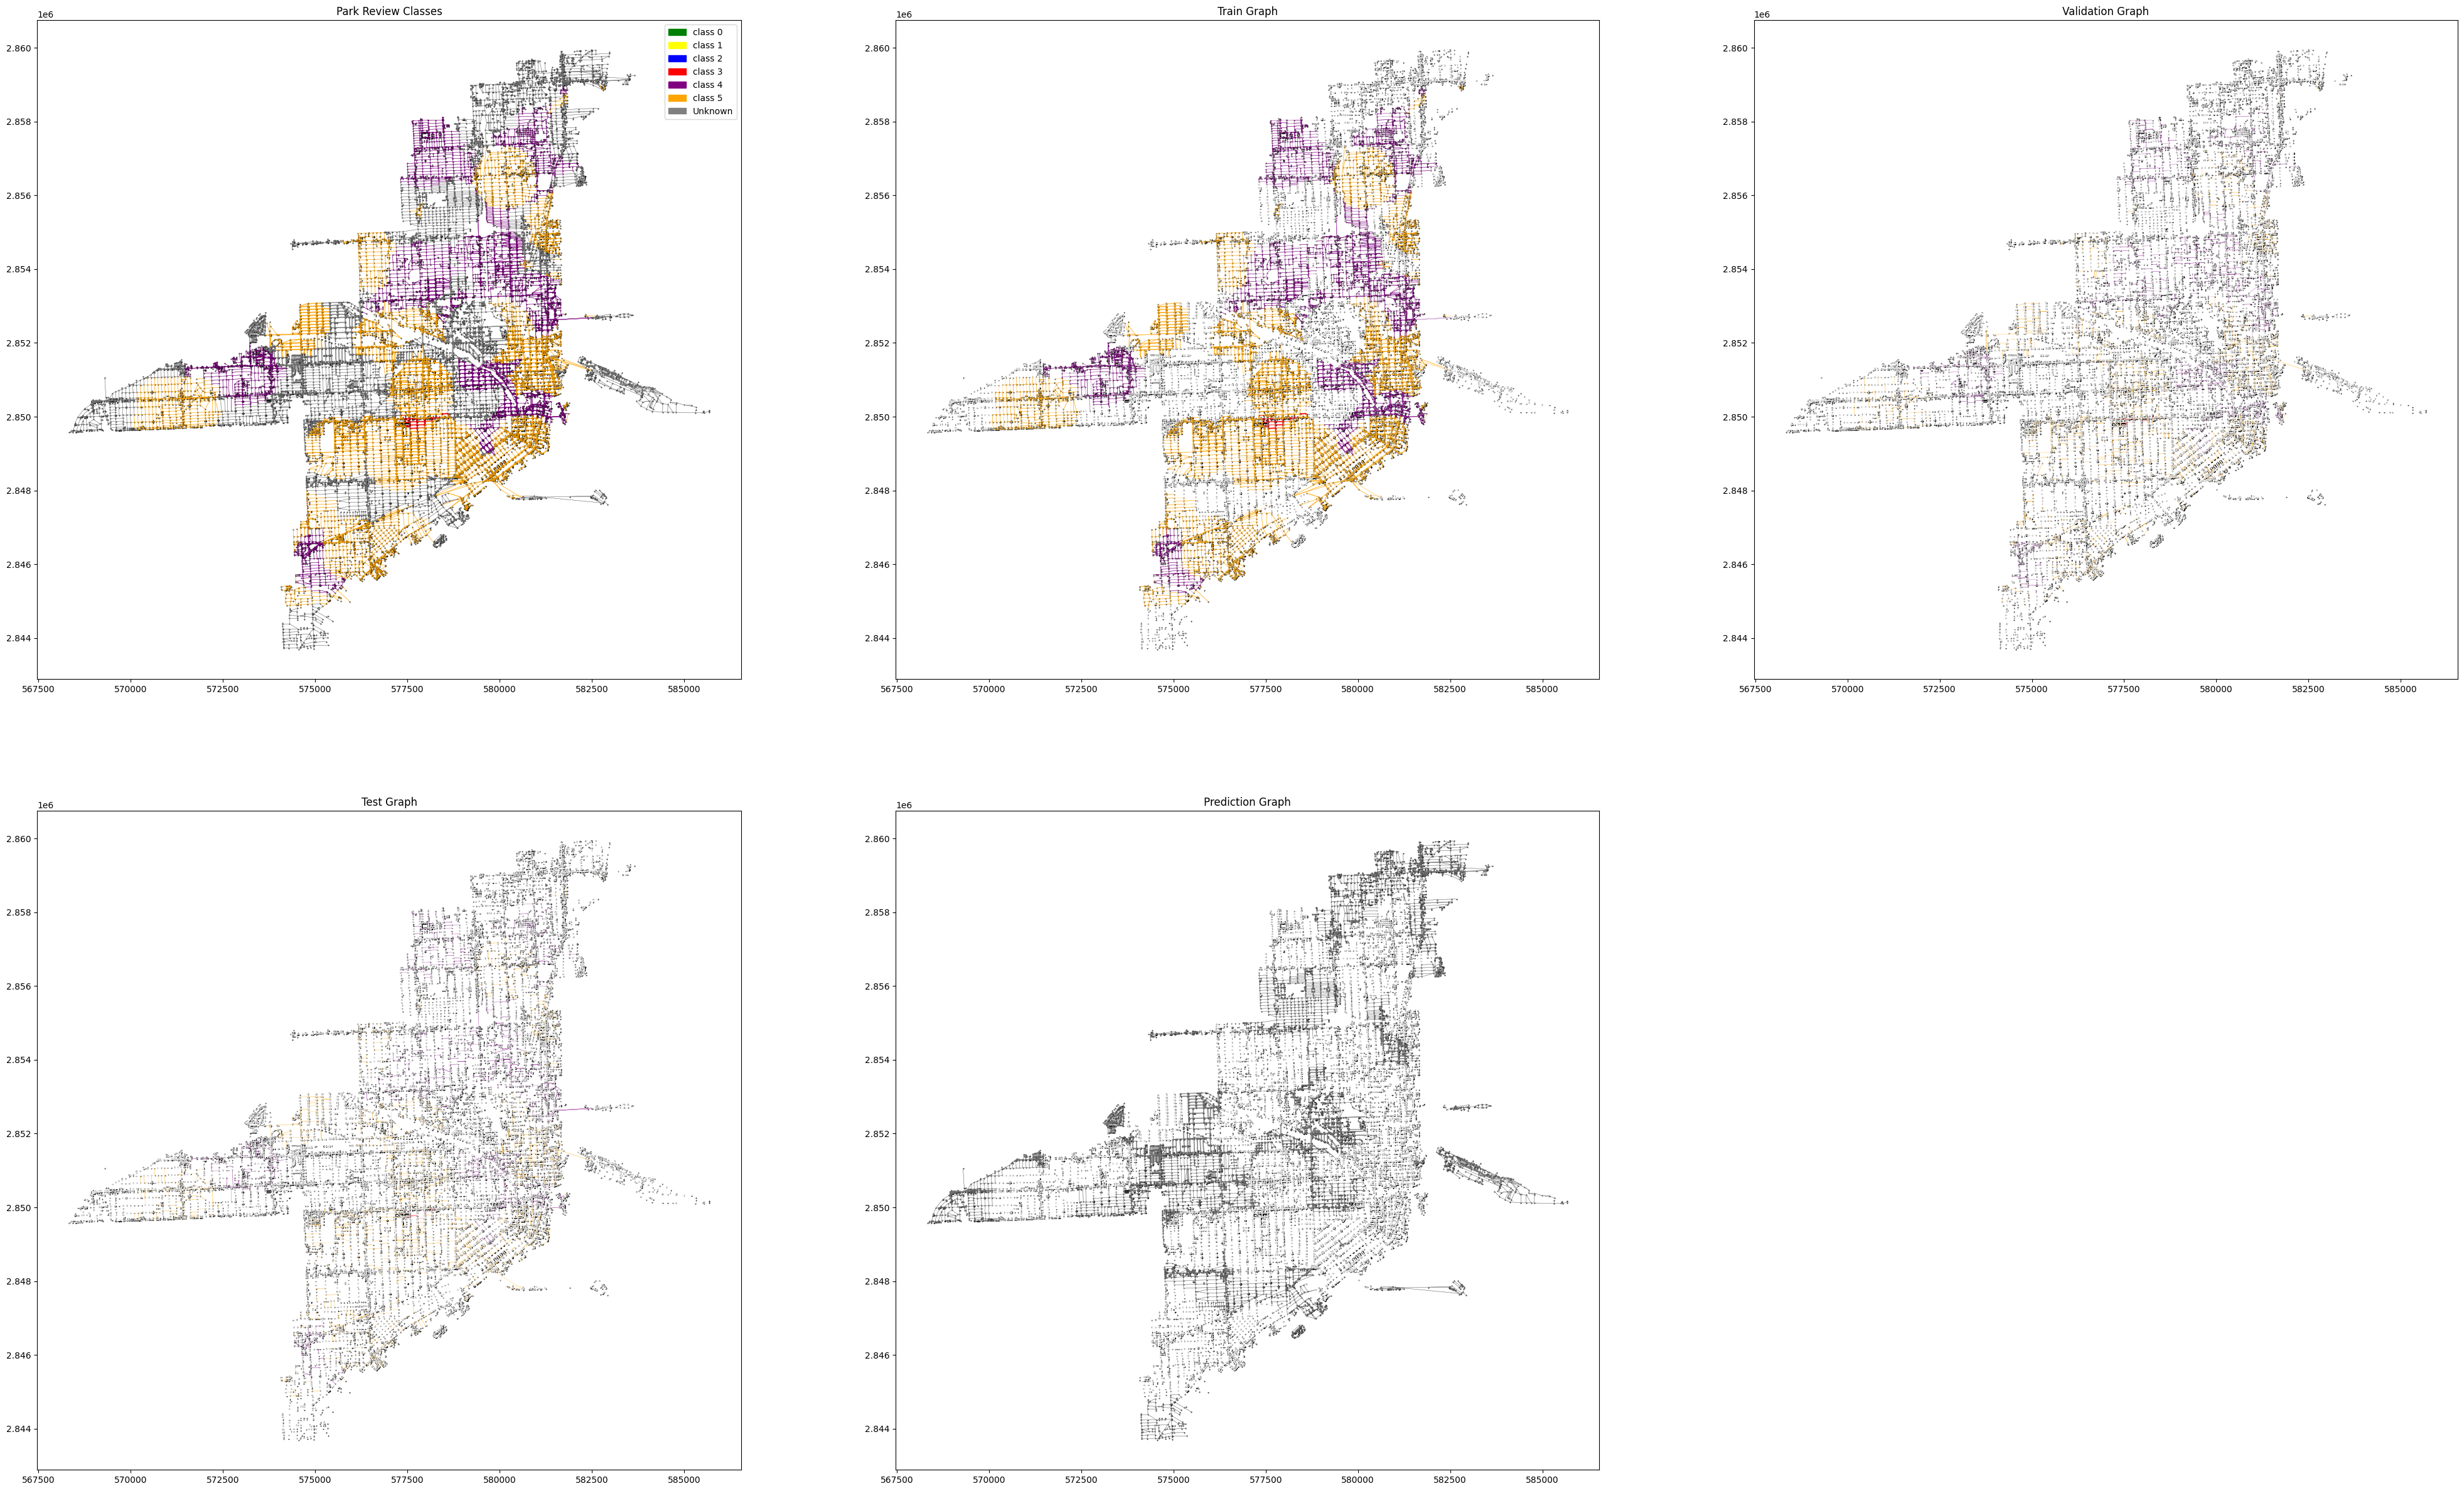

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import LineString, Point
import geopandas as gpd

# Extract node and edge geometries for plotting
node_coords = [(subgraph.nodes[node]['x'], subgraph.nodes[node]['y']) for node in subgraph.nodes]

# Initialize lists for edge geometries and edge classes
edge_geoms = []
edge_classes = []

# Adjust for MultiGraph by using correct unpacking and ensure all keys are accounted for
if subgraph.is_multigraph():
    for u, v, k in subgraph.edges(keys=True):
        edge_geoms.append(LineString([(subgraph.nodes[u]['x'], subgraph.nodes[u]['y']),
                                      (subgraph.nodes[v]['x'], subgraph.nodes[v]['y'])]))
        edge_classes.append(subgraph.edges[u, v, k]['edge_class'])
else:
    for u, v in subgraph.edges:
        edge_geoms.append(LineString([(subgraph.nodes[u]['x'], subgraph.nodes[u]['y']),
                                      (subgraph.nodes[v]['x'], subgraph.nodes[v]['y'])]))
        edge_classes.append(subgraph.edges[u, v]['edge_class'])

# Verify lengths match
print(f"edge_classes length: {len(edge_classes)}, edge_geoms length: {len(edge_geoms)}")
if len(edge_classes) != len(edge_geoms):
    raise ValueError("The length of edge_classes does not match the length of edge_geoms.")

# Create a GeoDataFrame for nodes and edges
node_gdf = gpd.GeoDataFrame({'geometry': [Point(coord) for coord in node_coords]}, crs='epsg:32617')
edge_gdf = gpd.GeoDataFrame({'geometry': edge_geoms, 'class': edge_classes}, crs='epsg:32617')

# Plot nodes and edges
fig, ax = plt.subplots(figsize=(15, 15))

# Plot nodes
node_gdf.plot(ax=ax, markersize=0.2, color="black")

# Set aspect ratio to 'auto' after plotting nodes
ax.set_aspect('auto')

# Color edges based on their class
he_colors_dict = {0: "green", 1: "yellow", 2: "blue", 3: "red", 4: "purple", 5: "orange", 6: "grey"}
he_colors = [he_colors_dict[cls] for cls in edge_gdf['class']]
edge_gdf.plot(ax=ax, color=he_colors, linewidth=0.3)

# Set title and legend
ax.set_title('Park Review Classes')
c0 = mpatches.Patch(color=he_colors_dict[0], label='class 0')
c1 = mpatches.Patch(color=he_colors_dict[1], label='class 1')
c2 = mpatches.Patch(color=he_colors_dict[2], label='class 2')
c3 = mpatches.Patch(color=he_colors_dict[3], label='class 3')
c4 = mpatches.Patch(color=he_colors_dict[4], label='class 4')
c5 = mpatches.Patch(color=he_colors_dict[5], label='class 5')
c6 = mpatches.Patch(color=he_colors_dict[6], label='Unknown')

plt.legend(handles=[c0, c1, c2, c3, c4, c5, c6])
plt.show()

# Define reorderings
edge_reorder_dict = {i: j for i, j in enumerate(edge_gdf.index)}
train_mask = {i: (m == 0) for i, m in enumerate(graph.edata['mask'].tolist())}
validation_mask = {i: (m == 1) for i, m in enumerate(graph.edata['mask'].tolist())}
test_mask = {i: (m == 2) for i, m in enumerate(graph.edata['mask'].tolist())}
prediction_mask = {i: (m == 3) for i, m in enumerate(graph.edata['mask'].tolist())}

# Prepare data for reordered classes and masks
classes_list = graph.edata['edge_class'].tolist()
classes_list_reordered = [classes_list[edge_reorder_dict[i]] for i in sorted(edge_reorder_dict.keys())]

# Plot Train, Validation, Test, and Prediction Graphs
fig = plt.figure(figsize=(50, 30))
out_of_mask_color = "white"

# Graph
ax = fig.add_subplot(2, 3, 1)
node_gdf.plot(ax=ax, markersize=0.2, color="black")
edge_gdf.plot(ax=ax, color=he_colors, linewidth=0.3)
ax.set_title('Park Review Classes')
plt.legend(handles=[c0, c1, c2, c3, c4, c5, c6])

# Train mask
ax = fig.add_subplot(2, 3, 2)
node_gdf.plot(ax=ax, markersize=0.2, color="black")
train_colors = [he_colors_dict[j] if train_mask[edge_reorder_dict[i]] else out_of_mask_color for i, j in enumerate(classes_list_reordered)]
edge_gdf.plot(ax=ax, color=train_colors, linewidth=0.3)
ax.set_title('Train Graph')

# Validation mask
ax = fig.add_subplot(2, 3, 3)
node_gdf.plot(ax=ax, markersize=0.2, color="black")
validation_colors = [he_colors_dict[j] if validation_mask[edge_reorder_dict[i]] else out_of_mask_color for i, j in enumerate(classes_list_reordered)]
edge_gdf.plot(ax=ax, color=validation_colors, linewidth=0.3)
ax.set_title('Validation Graph')

# Test mask
ax = fig.add_subplot(2, 3, 4)
node_gdf.plot(ax=ax, markersize=0.2, color="black")
test_colors = [he_colors_dict[j] if test_mask[edge_reorder_dict[i]] else out_of_mask_color for i, j in enumerate(classes_list_reordered)]
edge_gdf.plot(ax=ax, color=test_colors, linewidth=0.3)
ax.set_title('Test Graph')

# Prediction mask
ax = fig.add_subplot(2, 3, 5)
node_gdf.plot(ax=ax, markersize=0.2, color="black")
prediction_colors = [he_colors_dict[j] if prediction_mask[edge_reorder_dict[i]] else out_of_mask_color for i, j in enumerate(classes_list_reordered)]
edge_gdf.plot(ax=ax, color=prediction_colors, linewidth=0.3)
ax.set_title('Prediction Graph')

plt.show()


### 4.4: Adding Masks to the graph

In [ ]:
import torch

# Assign masks to graph edge data
graph.edata["train_mask"] = torch.tensor(list(train_mask.values()))
graph.edata["validation_mask"] = torch.tensor(list(validation_mask.values()))
graph.edata["test_mask"] = torch.tensor(list(test_mask.values()))
graph.edata["prediction_mask"] = torch.tensor(list(prediction_mask.values()))

# Verify the masks
print("Train mask:", graph.edata["train_mask"])
print("Validation mask:", graph.edata["validation_mask"])
print("Test mask:", graph.edata["test_mask"])
print("Prediction mask:", graph.edata["prediction_mask"])


Train mask: tensor([ True,  True,  True,  ..., False, False,  True])
Validation mask: tensor([False, False, False,  ..., False, False, False])
Test mask: tensor([False, False, False,  ..., False, False, False])
Prediction mask: tensor([False, False, False,  ...,  True,  True, False])


# 5: Learning

### 5.1: Node Embeddings

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv

class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = SAGEConv(in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = SAGEConv(in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h


### 5.2: Edge Predictor Model

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W1 = nn.Linear(in_features * 2, in_features)  # input is the size of hidden feature multiplied by 2 since it is the concatenation of the edge source and destination nodes
        self.W2 = nn.Linear(in_features, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        h = torch.cat([h_u, h_v], 1)  # concatenate the source and destination nodes' learned embedding vectors and input the resulting vector to an MLP to finally predict the edge class
        return {"score": self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']


### 5.3: Entire Classification Model

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, out_classes):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = MLPPredictor(out_features, out_classes)

    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)


### 5.4: Evaluation Function

In [ ]:
def evaluate(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)

        eval_loss = F.cross_entropy(logits, labels)
        correct = torch.sum(indices == labels)

        return correct.item() * 1.0 / len(labels), indices, eval_loss


### 5.5: Set Up Features, Labels, and Masks

In [ ]:
from collections import Counter

in_features = graph.ndata['feat'].shape[1]
num_classes = len(Counter([i.item() for i in graph.edata['edge_class']]))

node_features = graph.ndata['feat']
edge_label = graph.edata['edge_class']
train_mask1 = graph.edata['train_mask']
validation_mask1 = graph.edata['validation_mask']
test_mask1 = graph.edata['test_mask']


# 6: Training & Validation Loop

In [ ]:
print(f"Number of classes: {num_classes}")
print(f"Unique classes in edge_label: {torch.unique(edge_label)}")


Number of classes: 4
Unique classes in edge_label: tensor([3, 4, 5, 6])


In [ ]:
# Adjust edge labels to start from 0
min_class_index = edge_label.min().item()
edge_label = edge_label - min_class_index

# Now num_classes should be the range of adjusted edge labels
num_classes = len(torch.unique(edge_label))

print(f"Adjusted Number of classes: {num_classes}")
print(f"Adjusted unique classes in edge_label: {torch.unique(edge_label)}")


Adjusted Number of classes: 4
Adjusted unique classes in edge_label: tensor([0, 1, 2, 3])


In [ ]:
import torch.optim as optim

# Set hyperparameters
n_epochs = 600
lr = 0.003
n_hidden = 128
out_feat = 128

# Initialize the model
model = Model(in_features, n_hidden, out_feat, num_classes)
opt = optim.Adam(model.parameters(), lr=lr)

# Initialize lists to store loss and accuracy values for plotting
train_acc = []
train_loss = []

validation_acc = []
validation_loss = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    pred = model(graph, node_features)
    pred_argmax = pred.argmax(1)

    # Calculate the loss
    loss = F.cross_entropy(pred[train_mask1], edge_label[train_mask1])

    # Backpropagation and optimization
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Append training loss and accuracy
    train_loss.append(loss.item())
    t_acc = (pred_argmax[train_mask1] == edge_label[train_mask1]).float().mean().item()
    train_acc.append(t_acc)

    # Compute validation accuracy and loss
    acc, _, valid_loss = evaluate(model, node_features, edge_label, validation_mask1)
    validation_loss.append(valid_loss.item())
    validation_acc.append(acc)

    # Print training and validation metrics
    print(f'epoch: {epoch} | Train loss: {loss.item()} | Train accuracy: {t_acc} | Validation loss: {valid_loss.item()} | Validation accuracy: {acc}')


epoch: 0 | Train loss: 1.3741085529327393 | Train accuracy: 0.6555812954902649 | Validation loss: 1.091997504234314 | Validation accuracy: 0.6449661529598156
epoch: 1 | Train loss: 1.0855321884155273 | Train accuracy: 0.6555812954902649 | Validation loss: 0.9224871397018433 | Validation accuracy: 0.6449661529598156
epoch: 2 | Train loss: 0.9124452471733093 | Train accuracy: 0.6555812954902649 | Validation loss: 0.8157365322113037 | Validation accuracy: 0.6449661529598156
epoch: 3 | Train loss: 0.8033993244171143 | Train accuracy: 0.6555812954902649 | Validation loss: 0.7505099177360535 | Validation accuracy: 0.6449661529598156
epoch: 4 | Train loss: 0.7388387322425842 | Train accuracy: 0.6555812954902649 | Validation loss: 0.7071341276168823 | Validation accuracy: 0.6449661529598156
epoch: 5 | Train loss: 0.7000711560249329 | Train accuracy: 0.6555812954902649 | Validation loss: 0.7188769578933716 | Validation accuracy: 0.6449661529598156
epoch: 6 | Train loss: 0.7162045836448669 | Tra

In [ ]:
import numpy as np

# Check the balance of classes in the edge labels
class_counts = np.bincount(edge_label.numpy())
print(f"Class counts: {class_counts}")


Class counts: [  708 23534 45884 37470]


# 7: Making Predictions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import LineString, Point
import geopandas as gpd
import numpy as np


In [ ]:
# Map adjusted class numbers back to original class numbers
original_class_mapping = {0: 3, 1: 4, 2: 5, 3: 6}
predicted_classes_original = np.array([original_class_mapping[cls] for cls in indices.numpy()])
true_classes_original = np.array([original_class_mapping[cls] for cls in labels.numpy()])


In [ ]:
# Extract node and edge geometries for plotting
node_coords = [(subgraph.nodes[node]['x'], subgraph.nodes[node]['y']) for node in subgraph.nodes]

# Initialize lists for edge geometries and classes
edge_geoms = []
edge_classes = []
for u, v, k in subgraph.edges(keys=True):
    edge_geoms.append(LineString([(subgraph.nodes[u]['x'], subgraph.nodes[u]['y']),
                                  (subgraph.nodes[v]['x'], subgraph.nodes[v]['y'])]))
    edge_classes.append(subgraph.edges[u, v, k]['edge_class'])

# Create a GeoDataFrame for nodes and edges
node_gdf = gpd.GeoDataFrame({'geometry': [Point(coord) for coord in node_coords]}, crs='epsg:32617')
edge_gdf = gpd.GeoDataFrame({'geometry': edge_geoms, 'class': edge_classes}, crs='epsg:32617')


In [ ]:
# Filter edge_gdf for different masks
train_edge_indices = [i for i, mask in enumerate(train_mask1.numpy()) if mask]
test_edge_indices = [i for i, mask in enumerate(test_mask1.numpy()) if mask]

train_edge_gdf = edge_gdf.iloc[train_edge_indices].copy()
test_edge_gdf = edge_gdf.iloc[test_edge_indices].copy()

# Assign predicted classes to the test_edge_gdf
test_edge_gdf['class'] = predicted_classes_original


In [ ]:
# Combine training and predicted data
combined_edge_gdf = pd.concat([train_edge_gdf, test_edge_gdf])

# Ensure the combined dataset has the correct classes
combined_edge_classes = np.concatenate([train_edge_gdf['class'], predicted_classes_original])
combined_edge_gdf['class'] = combined_edge_classes


In [ ]:
# Calculate statistics for original dataset (training only)
original_class_counts = train_edge_gdf['class'].value_counts().to_dict()
original_total_edges = len(train_edge_gdf)

# Calculate statistics for post-prediction dataset (training + predicted)
post_prediction_class_counts = combined_edge_gdf['class'].value_counts().to_dict()
post_prediction_total_edges = len(combined_edge_gdf)


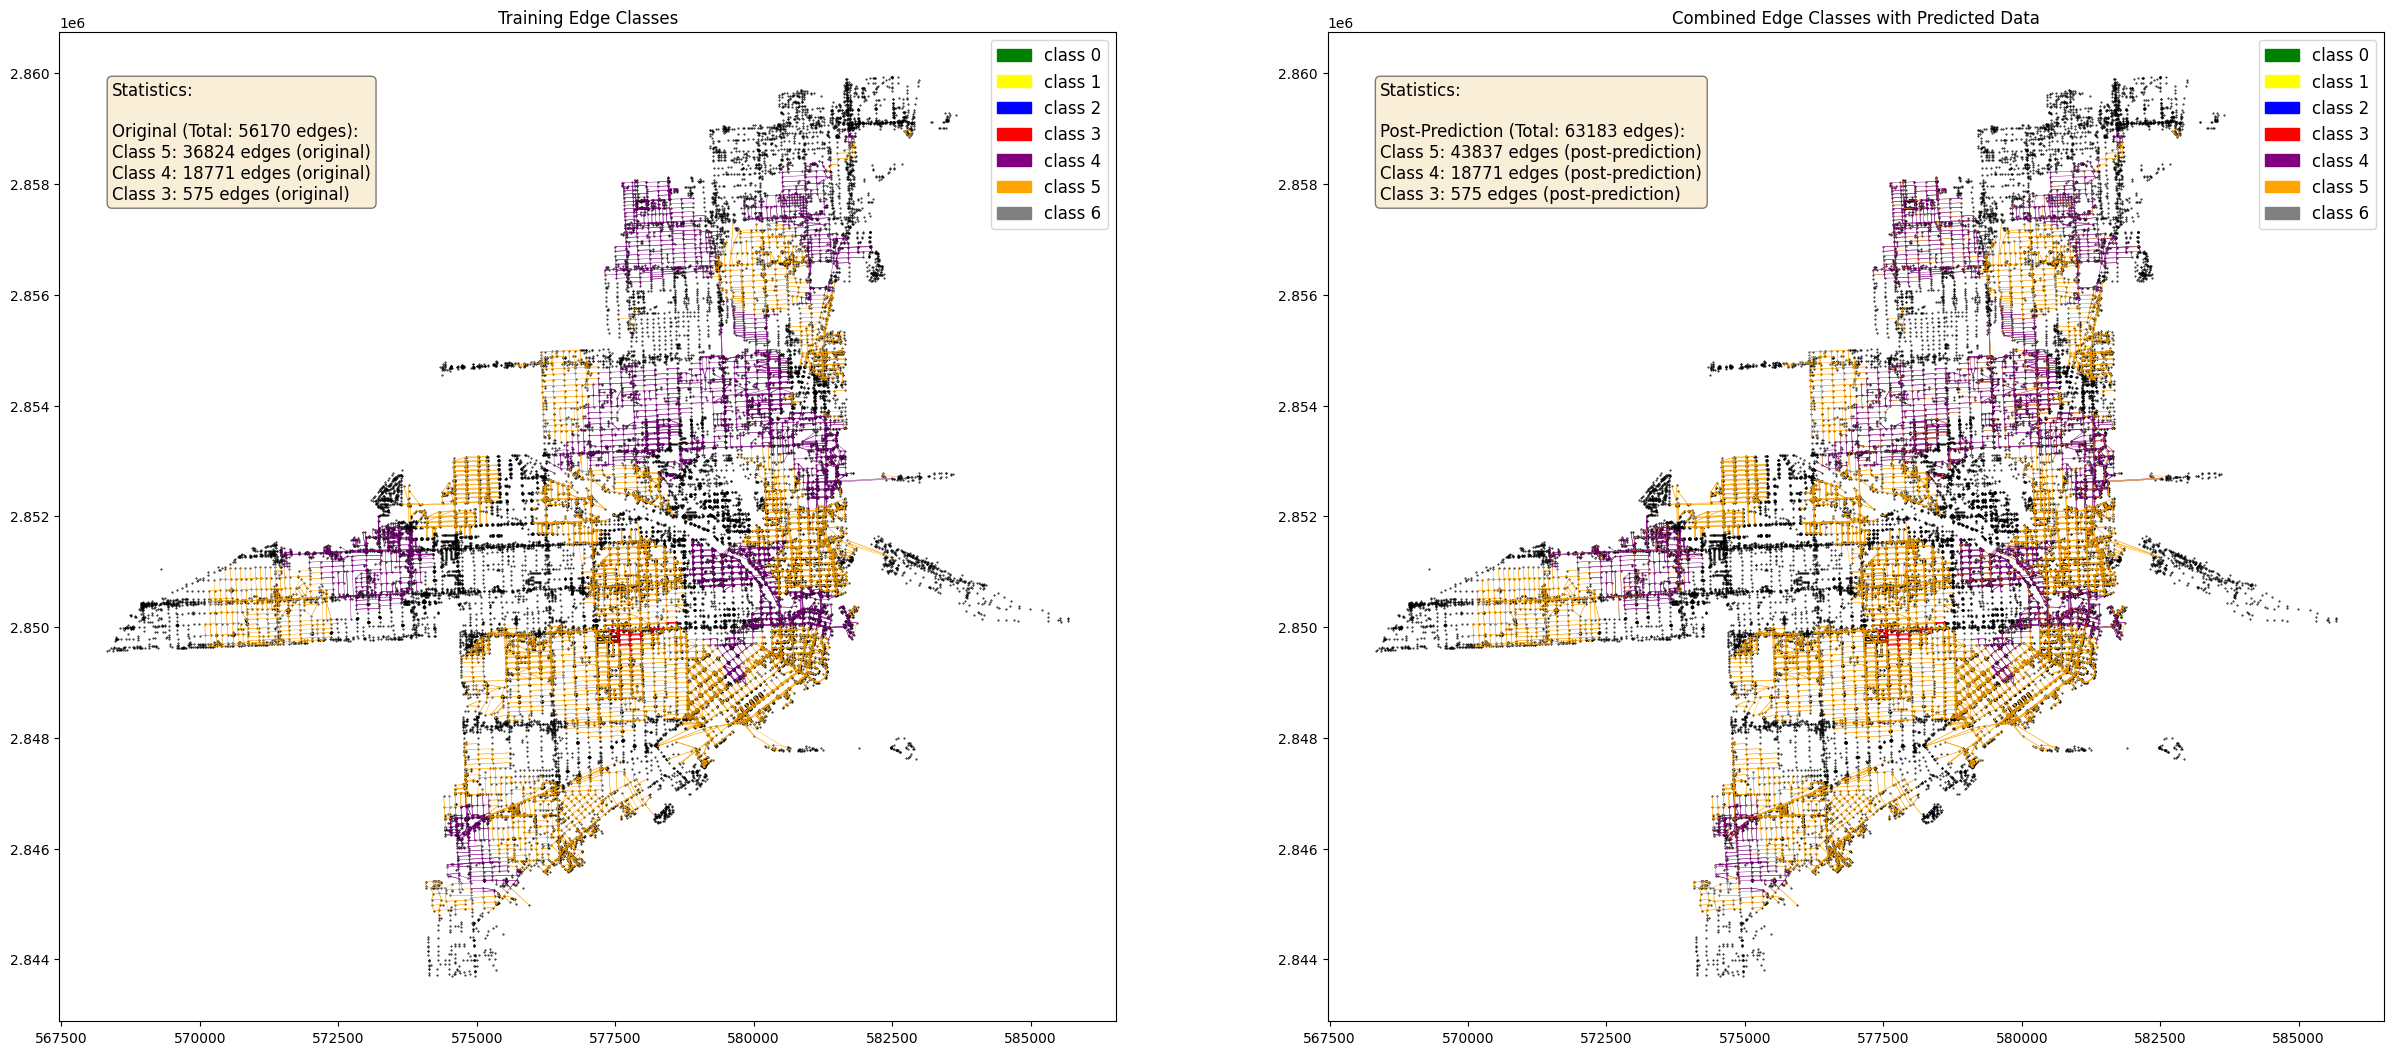

In [ ]:
# Color map for the classes (same as provided)
he_colors_dict = {0: "green", 1: "yellow", 2: "blue", 3: "red", 4: "purple", 5: "orange", 6: "grey"}

# Plot the training and combined datasets
fig, axs = plt.subplots(1, 2, figsize=(30, 15))

# Plot training edges
axs[0].set_title(f'Training Edge Classes')
node_gdf.plot(ax=axs[0], markersize=0.2, color="black")
train_edge_colors = [he_colors_dict[cls] for cls in train_edge_gdf['class']]
train_edge_gdf.plot(ax=axs[0], color=train_edge_colors, linewidth=0.3)

# Plot combined edges
axs[1].set_title(f'Combined Edge Classes with Predicted Data')
node_gdf.plot(ax=axs[1], markersize=0.2, color="black")
combined_edge_colors = [he_colors_dict[cls] for cls in combined_edge_gdf['class']]
combined_edge_gdf.plot(ax=axs[1], color=combined_edge_colors, linewidth=0.3)

# Create legends
patches = [mpatches.Patch(color=color, label=f'class {cls}') for cls, color in he_colors_dict.items()]
axs[0].legend(handles=patches, fontsize=12)
axs[1].legend(handles=patches, fontsize=12)

# Display statistics
original_stats = '\n'.join([f'Class {cls}: {count} edges (original)' for cls, count in original_class_counts.items()])
post_prediction_stats = '\n'.join([f'Class {cls}: {count} edges (post-prediction)' for cls, count in post_prediction_class_counts.items()])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
stats_text_0 = f'Statistics:\n\nOriginal (Total: {original_total_edges} edges):\n{original_stats}'
stats_text_1 = f'Statistics:\n\nPost-Prediction (Total: {post_prediction_total_edges} edges):\n{post_prediction_stats}'
axs[0].text(0.05, 0.95, stats_text_0, transform=axs[0].transAxes, fontsize=12, verticalalignment='top', bbox=props)
axs[1].text(0.05, 0.95, stats_text_1, transform=axs[1].transAxes, fontsize=12, verticalalignment='top', bbox=props)

plt.show()


In [ ]:
# Color map for the classes (same as provided)
he_colors_dict = {0: "green", 1: "yellow", 2: "blue", 3: "red", 4: "purple", 5: "orange", 6: "grey"}

# Calculate statistics for original dataset (training only)
original_class_counts = train_edge_gdf['class'].value_counts().to_dict()
original_total_edges = len(train_edge_gdf)

# Calculate statistics for post-prediction dataset (training + predicted)
post_prediction_class_counts = combined_edge_gdf['class'].value_counts().to_dict()
post_prediction_total_edges = len(combined_edge_gdf)

# Calculate how many unknown edges were predicted for each class
predicted_unknown_edges = combined_edge_gdf[combined_edge_gdf.index.isin(test_edge_gdf.index)]
predicted_class_counts = predicted_unknown_edges['class'].value_counts().to_dict()

print(f'Original class counts: {original_class_counts}')
print(f'Post-prediction class counts: {post_prediction_class_counts}')
print(f'Predicted unknown edges by class: {predicted_class_counts}')


Original class counts: {5: 36824, 4: 18771, 3: 575}
Post-prediction class counts: {5: 43837, 4: 18771, 3: 575}
Predicted unknown edges by class: {5: 7013}


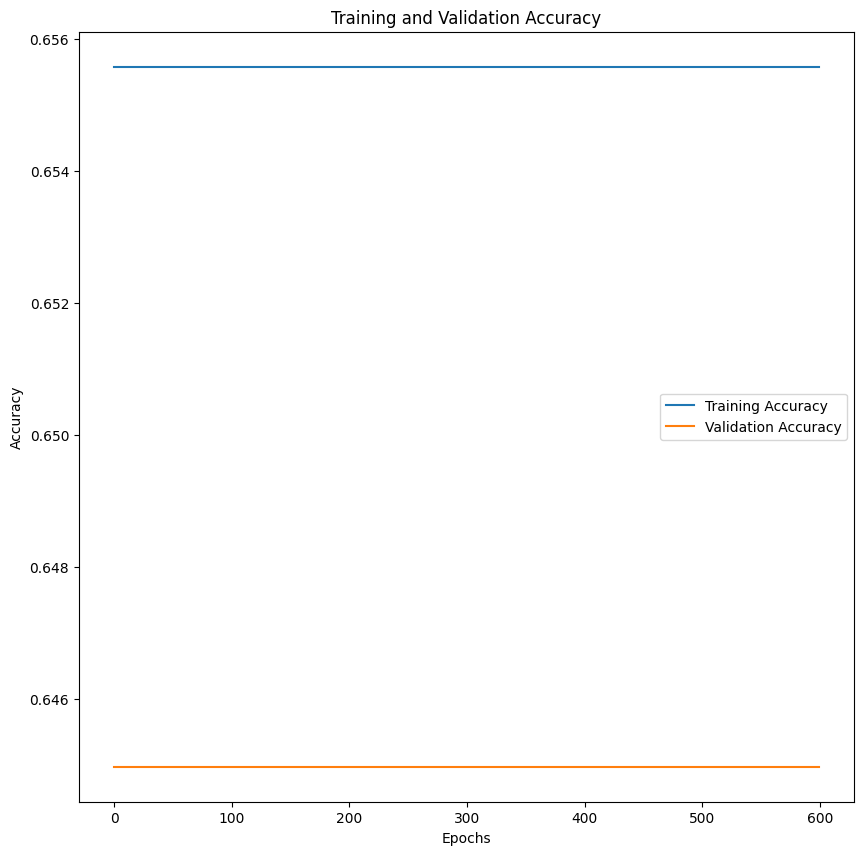

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation accuracy
plt.plot(range(n_epochs), train_acc, label='Training Accuracy')
plt.plot(range(n_epochs), validation_acc, label='Validation Accuracy')

# Add title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display the plot
plt.legend(loc='best')
plt.show()


In [ ]:
# Print sample values from train_acc and validation_acc
print("Sample training accuracies:", train_acc[:10])
print("Sample validation accuracies:", validation_acc[:10])


Sample training accuracies: [0.6555812954902649, 0.6555812954902649, 0.6555812954902649, 0.6555812954902649, 0.6555812954902649, 0.6555812954902649, 0.6555812954902649, 0.6555812954902649, 0.6555812954902649, 0.6555812954902649]
Sample validation accuracies: [0.6449661529598156, 0.6449661529598156, 0.6449661529598156, 0.6449661529598156, 0.6449661529598156, 0.6449661529598156, 0.6449661529598156, 0.6449661529598156, 0.6449661529598156, 0.6449661529598156]


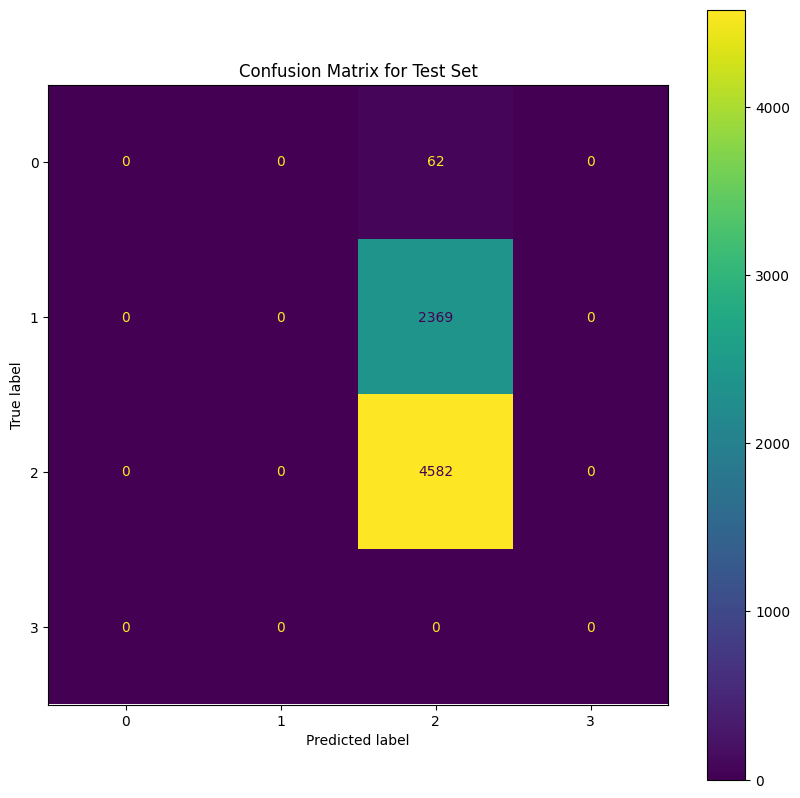

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Obtain predictions for the test set
with torch.no_grad():
    test_pred = model(graph, node_features)
    test_pred_argmax = test_pred.argmax(1)

# Extract true labels and predictions for the test set
y_test = edge_label[test_mask1].cpu().numpy()
predictions = test_pred_argmax[test_mask1].cpu().numpy()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=[0, 1, 2, 3])  # Adjust labels based on your actual classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title('Confusion Matrix for Test Set')
plt.show()
